In [93]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [94]:
# Load the sales dataset
import pandas as pd
train = pd.read_csv('train.csv',index_col=0,parse_dates=['date'])
train.head()

date  store_nbr      family  sales  onpromotion
id                                                      
0  2013-01-01          1  AUTOMOTIVE    0.0            0
1  2013-01-01          1   BABY CARE    0.0            0
2  2013-01-01          1      BEAUTY    0.0            0
3  2013-01-01          1   BEVERAGES    0.0            0
4  2013-01-01          1       BOOKS    0.0            0

In [95]:
# Retrieve the descriptibe statistics of the sales dataset
train.describe()

date     store_nbr         sales   onpromotion
count                        3000888  3.000888e+06  3.000888e+06  3.000888e+06
mean   2015-04-24 08:27:04.703088384  2.750000e+01  3.577757e+02  2.602770e+00
min              2013-01-01 00:00:00  1.000000e+00  0.000000e+00  0.000000e+00
25%              2014-02-26 18:00:00  1.400000e+01  0.000000e+00  0.000000e+00
50%              2015-04-24 12:00:00  2.750000e+01  1.100000e+01  0.000000e+00
75%              2016-06-19 06:00:00  4.100000e+01  1.958473e+02  0.000000e+00
max              2017-08-15 00:00:00  5.400000e+01  1.247170e+05  7.410000e+02
std                              NaN  1.558579e+01  1.101998e+03  1.221888e+01

In [96]:
# Check for missing values in the sales dataset
train.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [97]:
# There are no missing or negative values in the sales dataset
# Retrieve the month for each of the entry
train['month'] = train['date'].dt.month
# Obtain monthly sales totals for each store
monthly_sales_totals = train.groupby(['store_nbr','month'])['sales'].sum().to_frame('monthly_sales_totals').reset_index()
monthly_sales_totals.head()

store_nbr  month  monthly_sales_totals
0          1      1          1.297219e+06
1          1      2          1.034553e+06
2          1      3          1.294979e+06
3          1      4          1.181384e+06
4          1      5          1.186763e+06

In [98]:
# Define functions to find outliers using Z-score and IQR
def Z(x: pd.Series,threshold=3):
    return ((x-x.mean())/x.std()).abs() > threshold
def IQR(x: pd.Series):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3-q1
    return (x < q1-1.5*iqr) | (x > q3+1.5*iqr)
# Find outliers by considering values which are considered extreme by either Z-score or IQR
monthly_sales_totals['outlier'] = Z(monthly_sales_totals['monthly_sales_totals'])
monthly_sales_totals['outlier'] |= IQR(monthly_sales_totals['monthly_sales_totals'])
monthly_sales_totals.head()

store_nbr  month  monthly_sales_totals  outlier
0          1      1          1.297219e+06    False
1          1      2          1.034553e+06    False
2          1      3          1.294979e+06    False
3          1      4          1.181384e+06    False
4          1      5          1.186763e+06    False

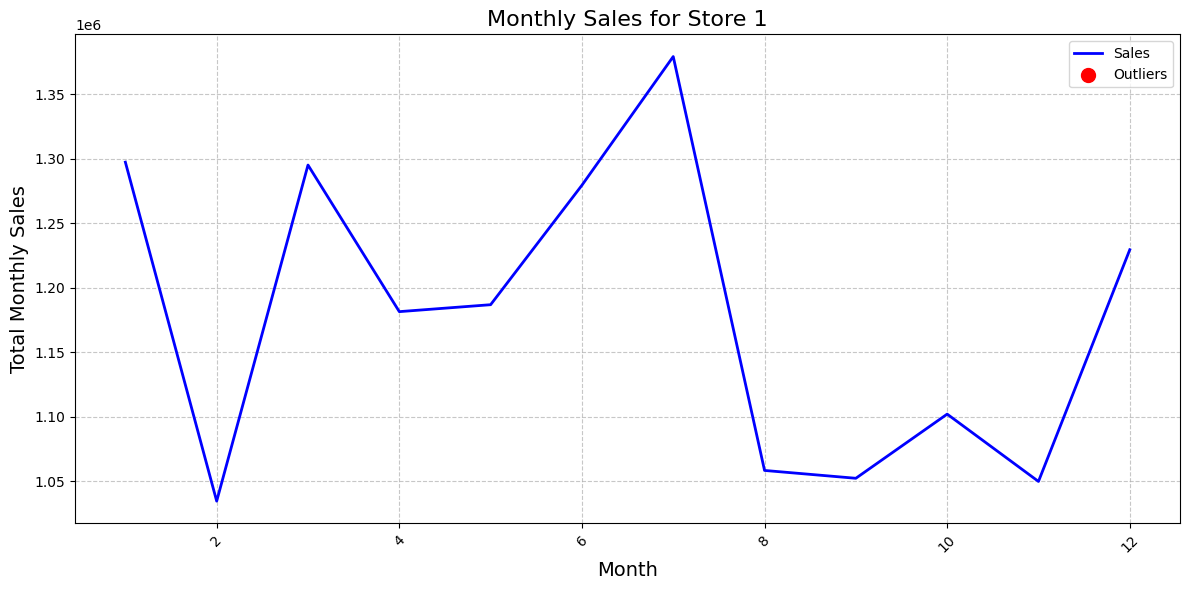

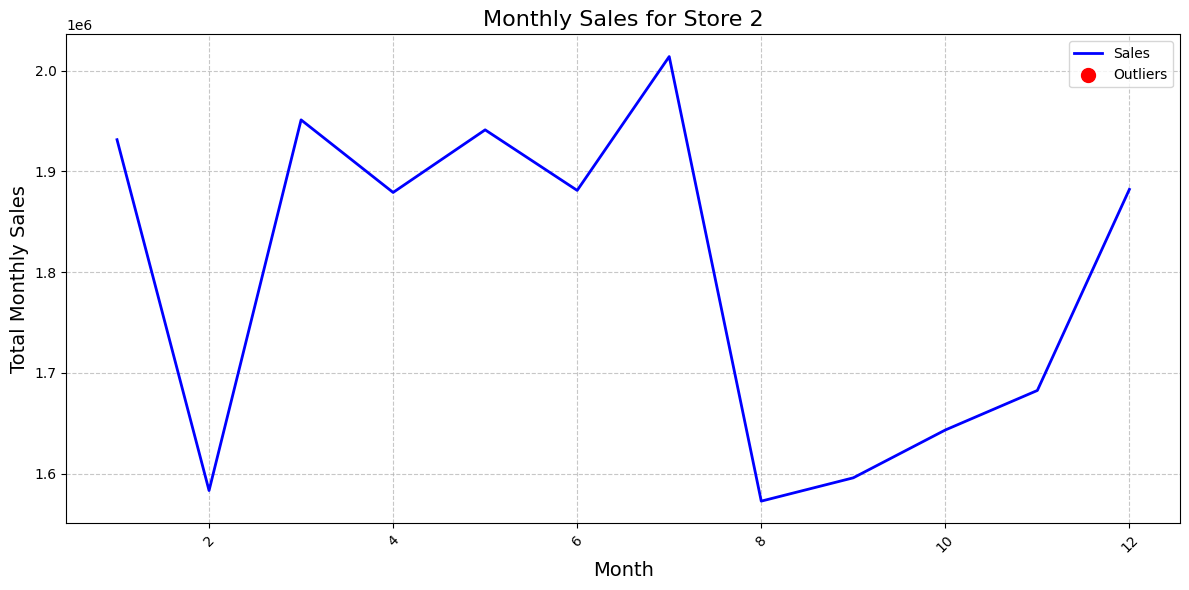

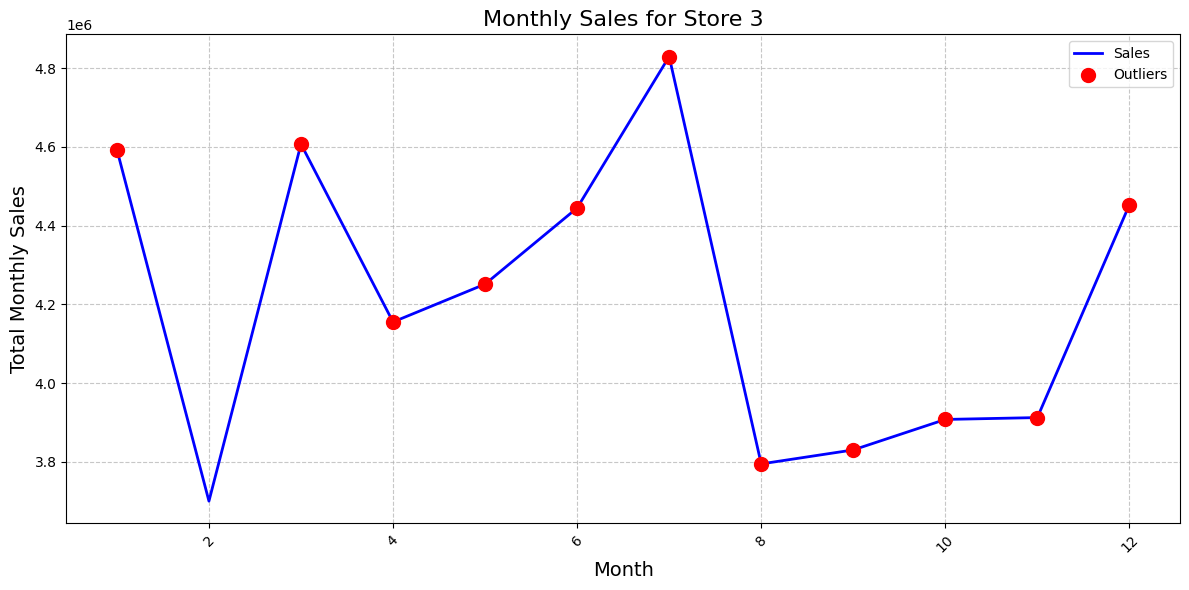

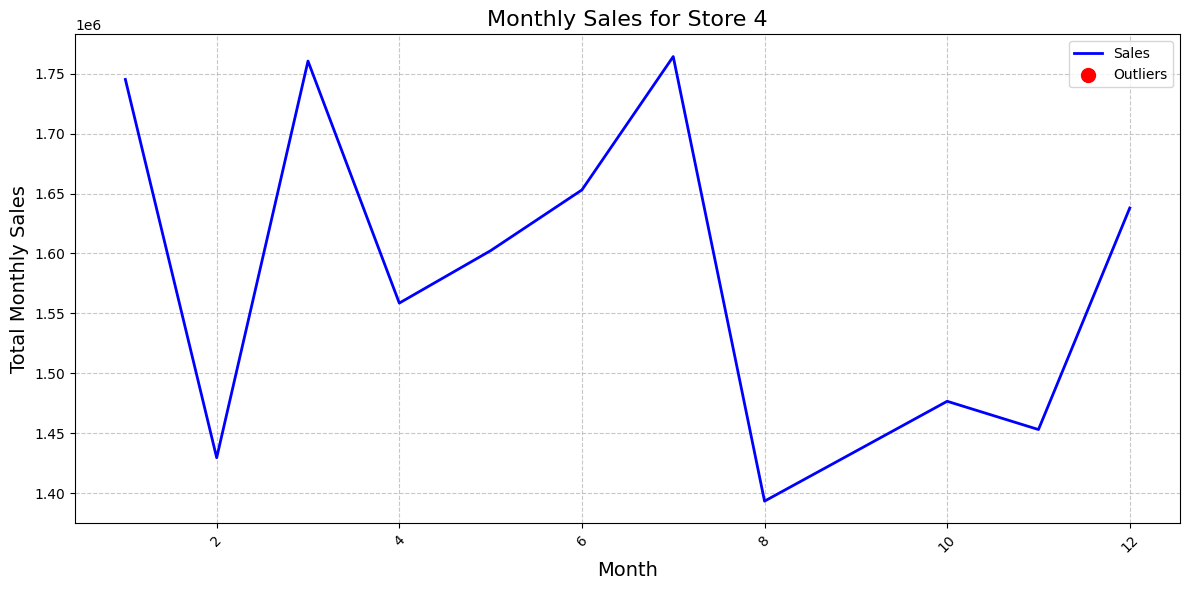

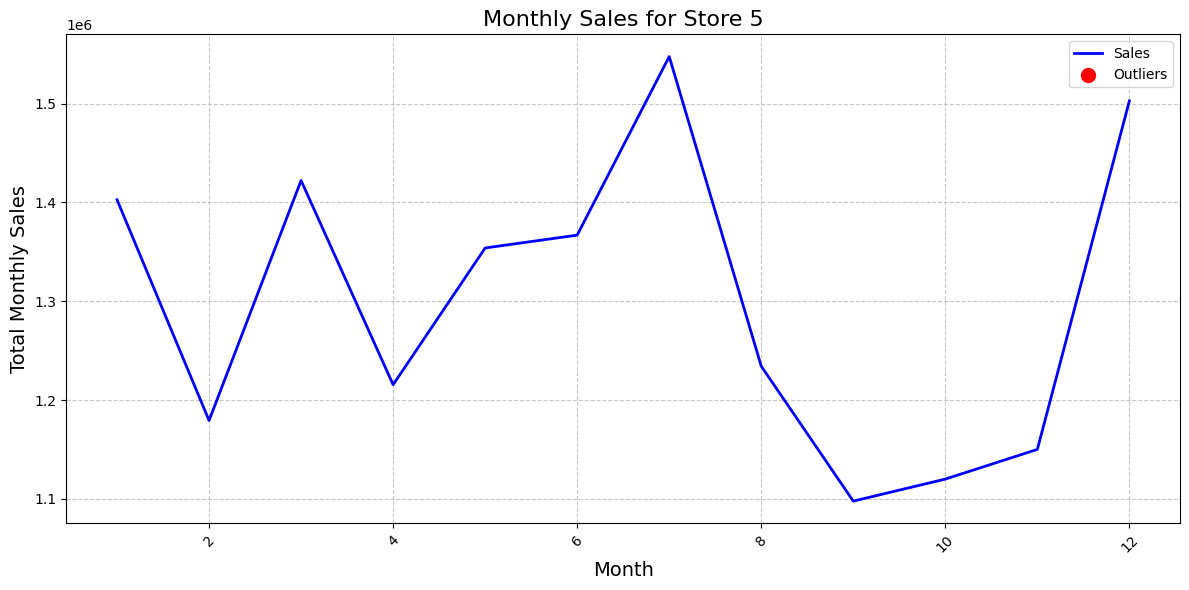

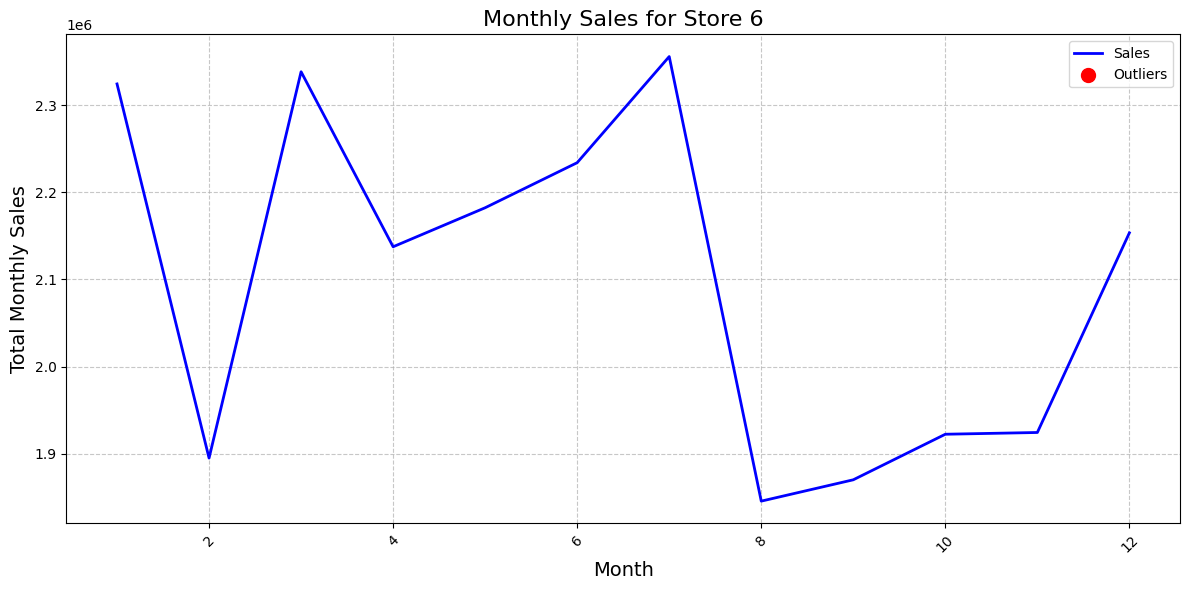

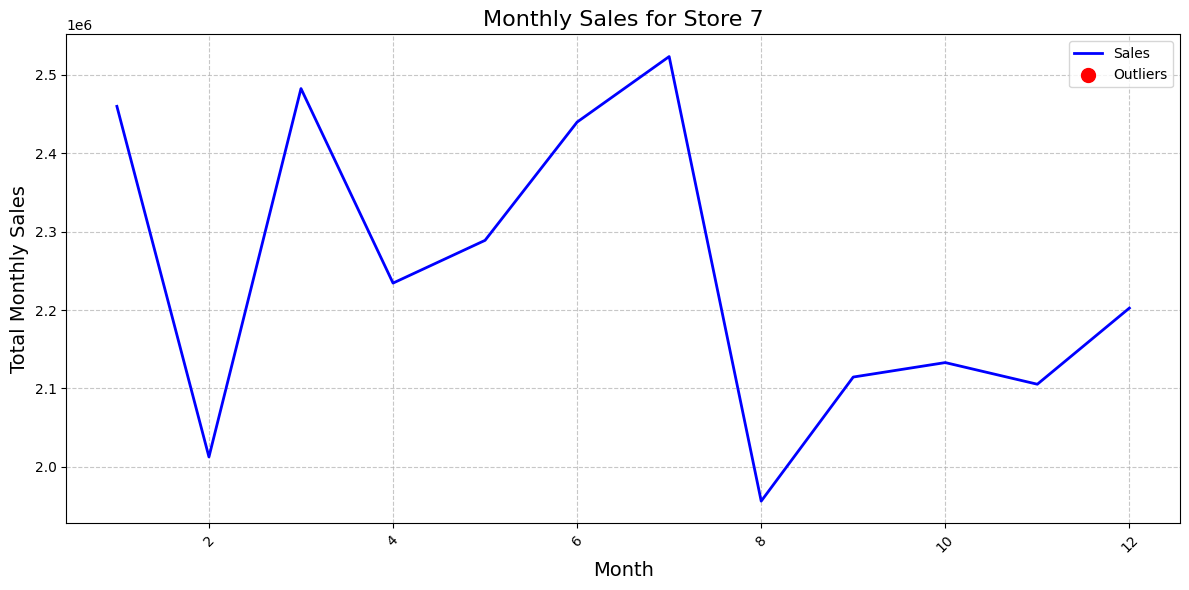

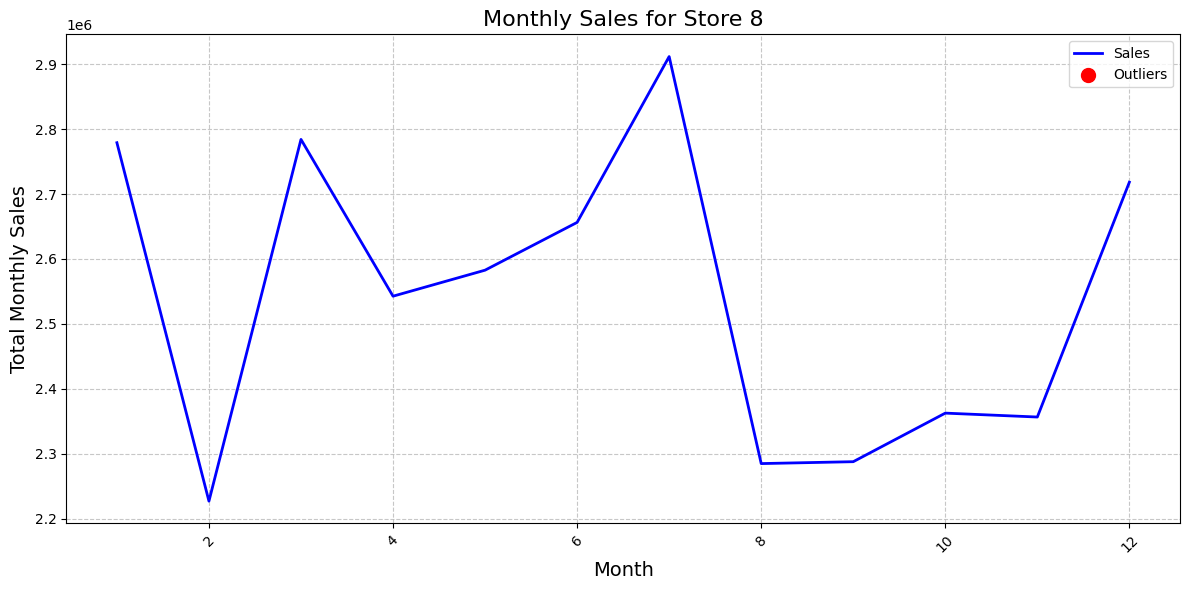

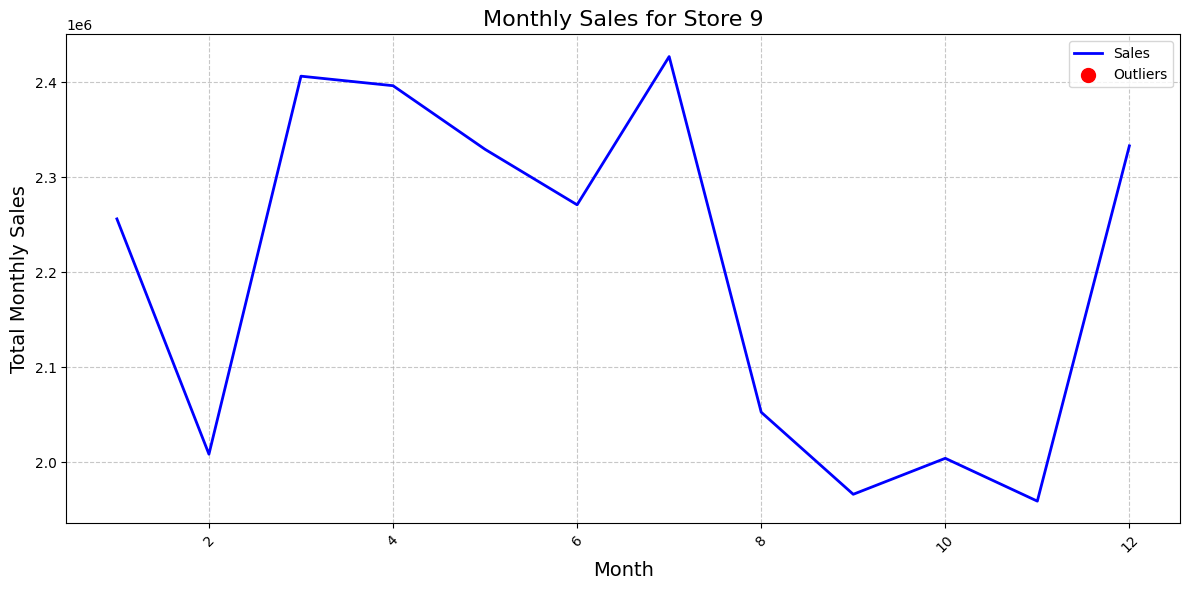

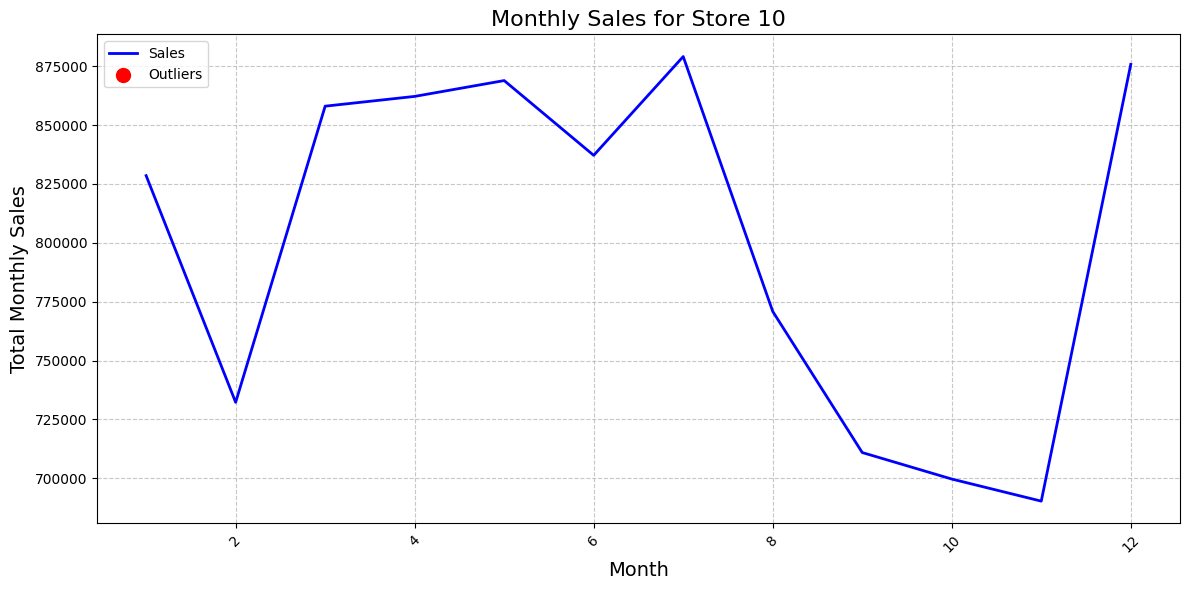

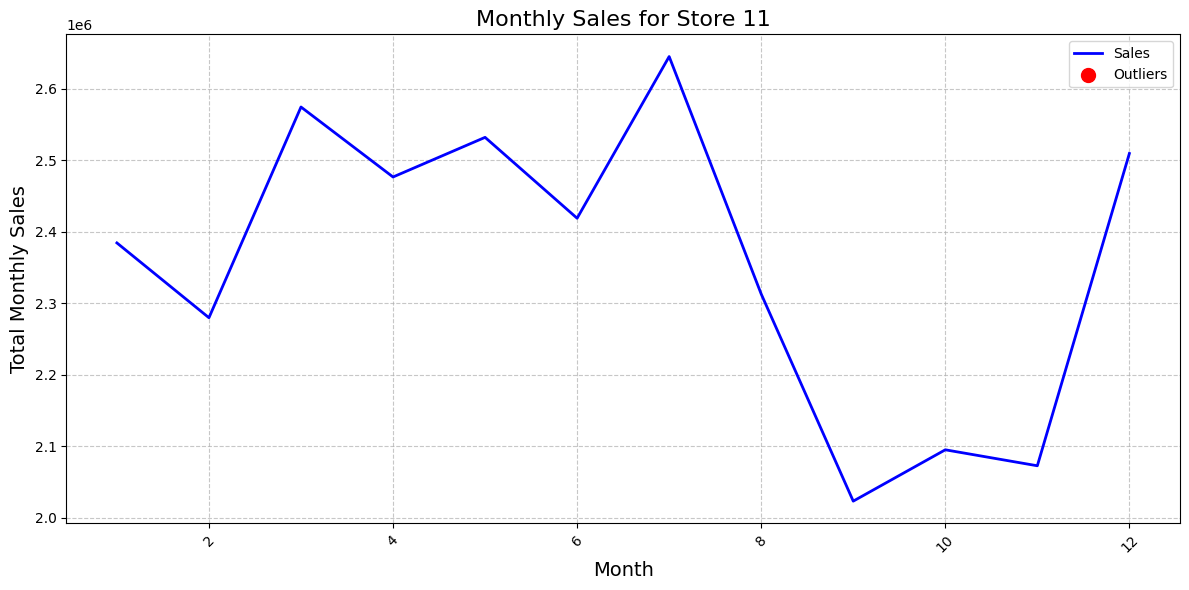

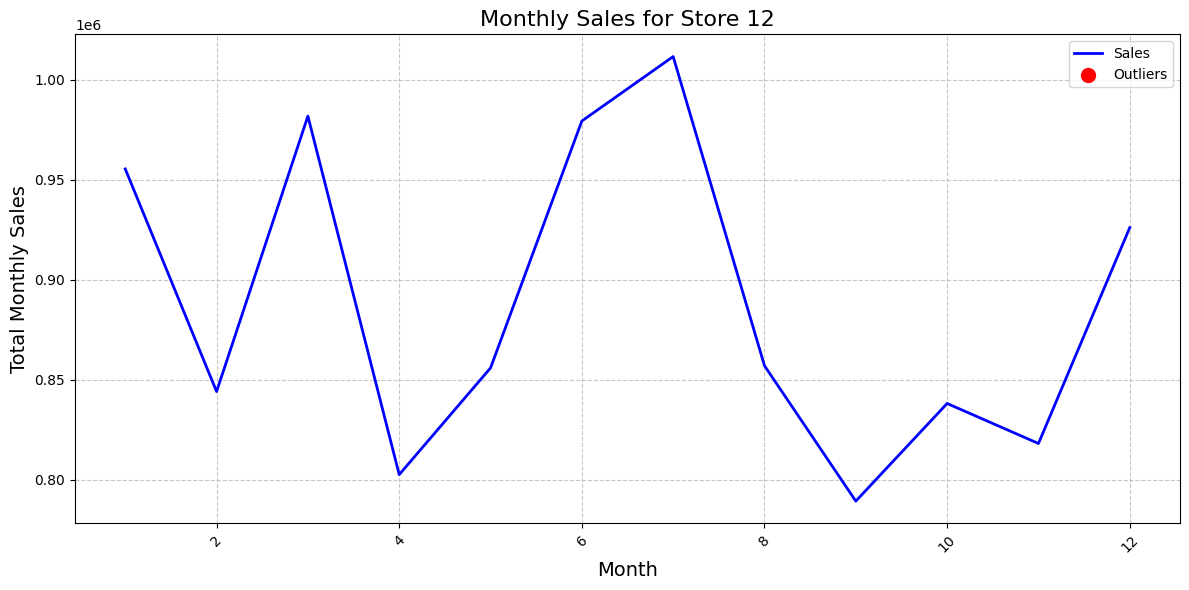

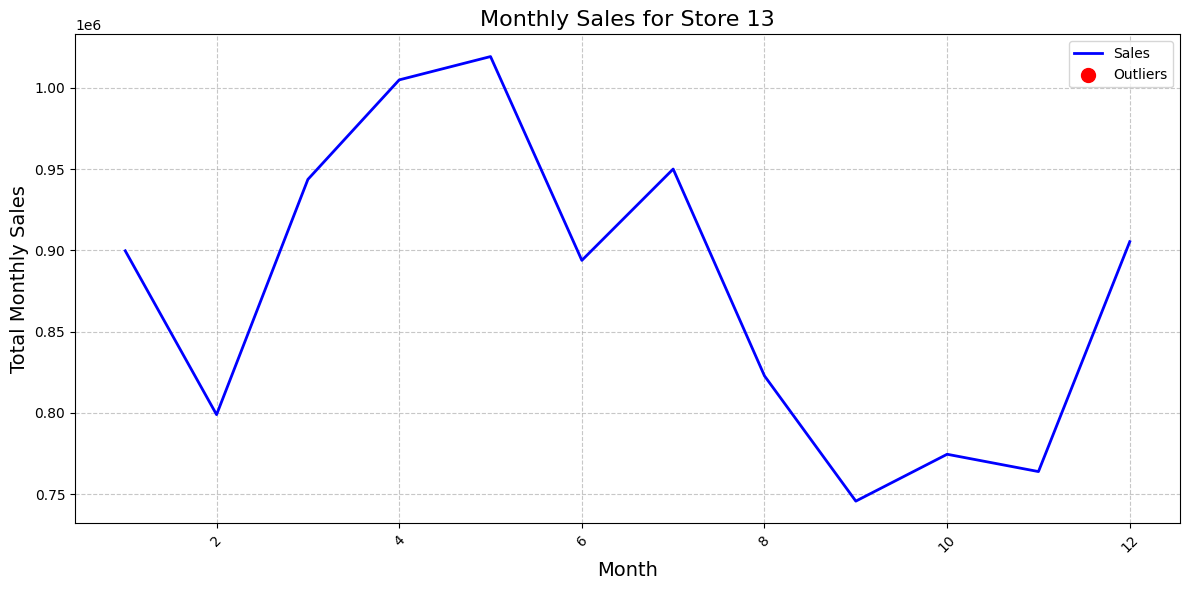

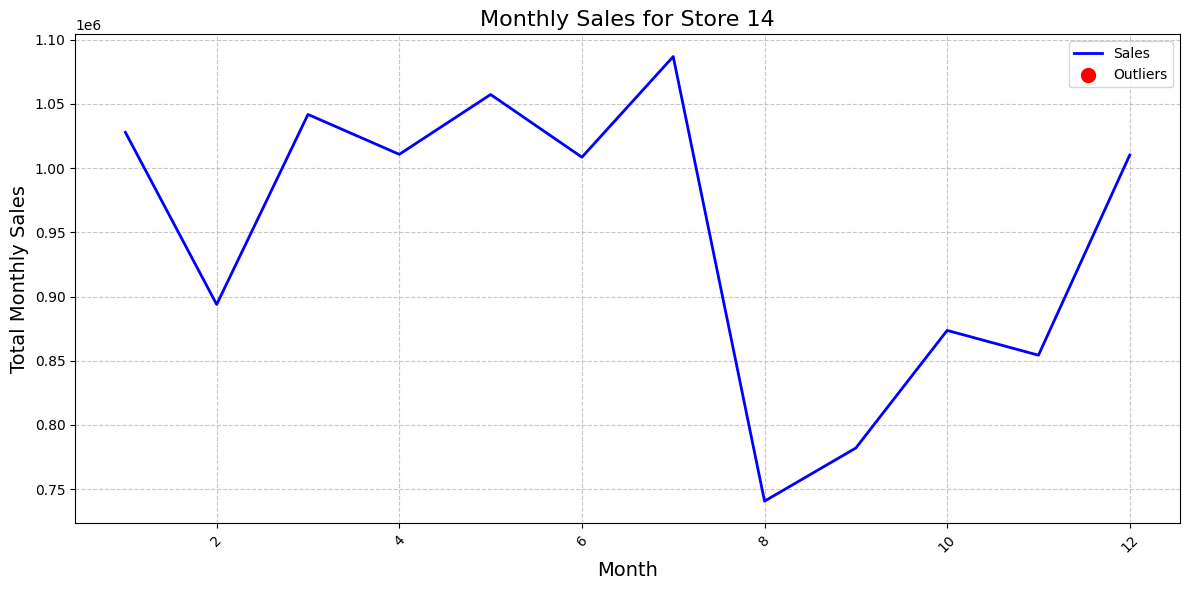

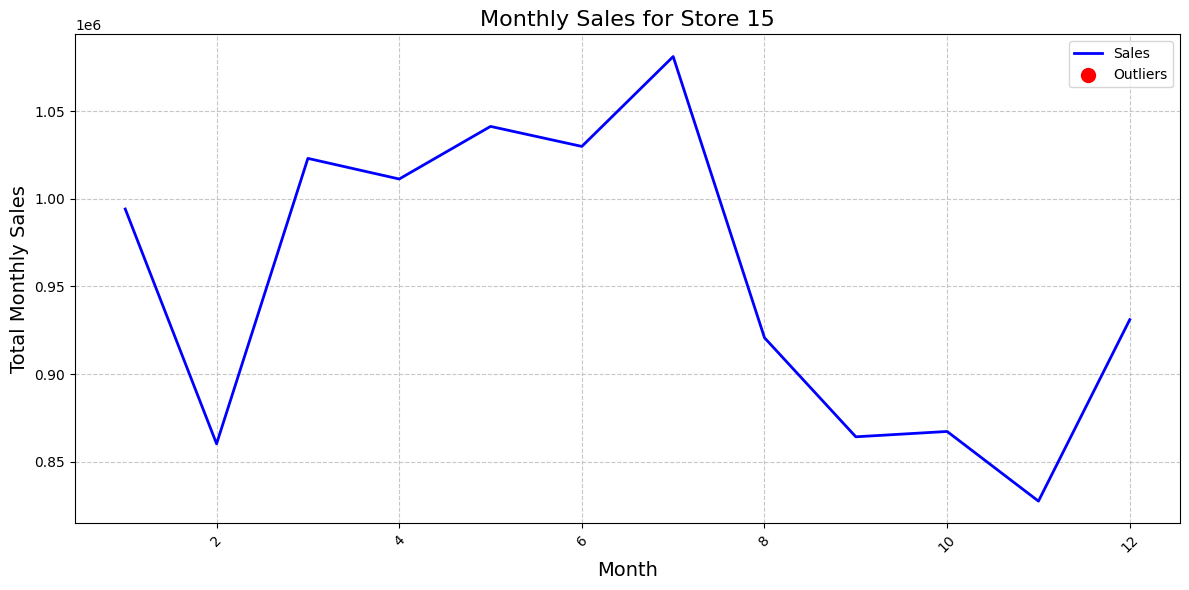

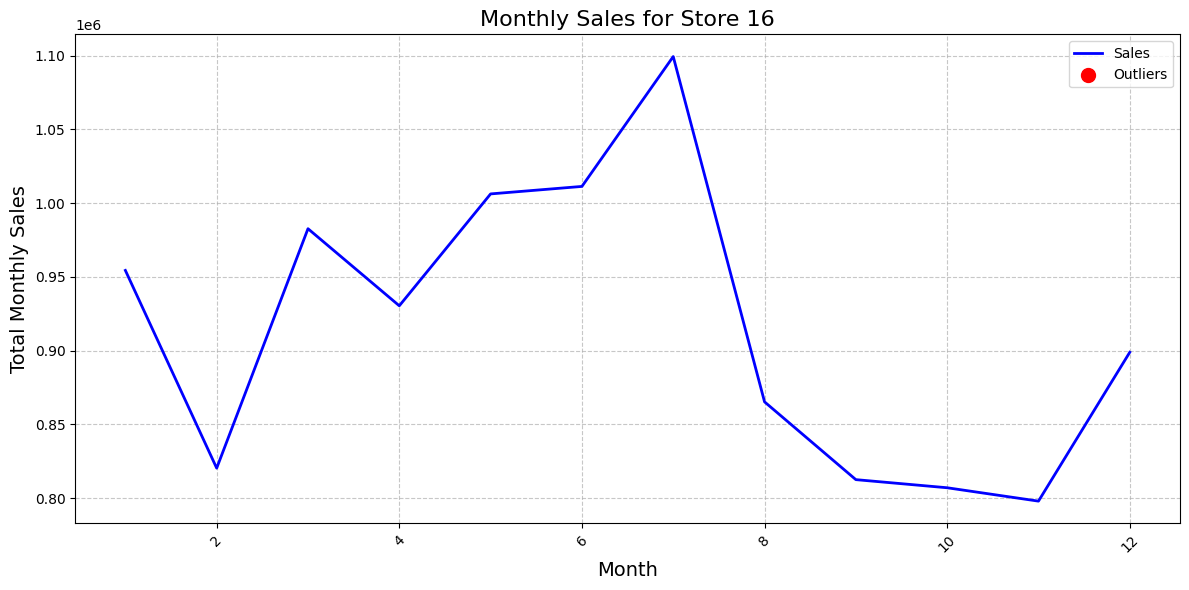

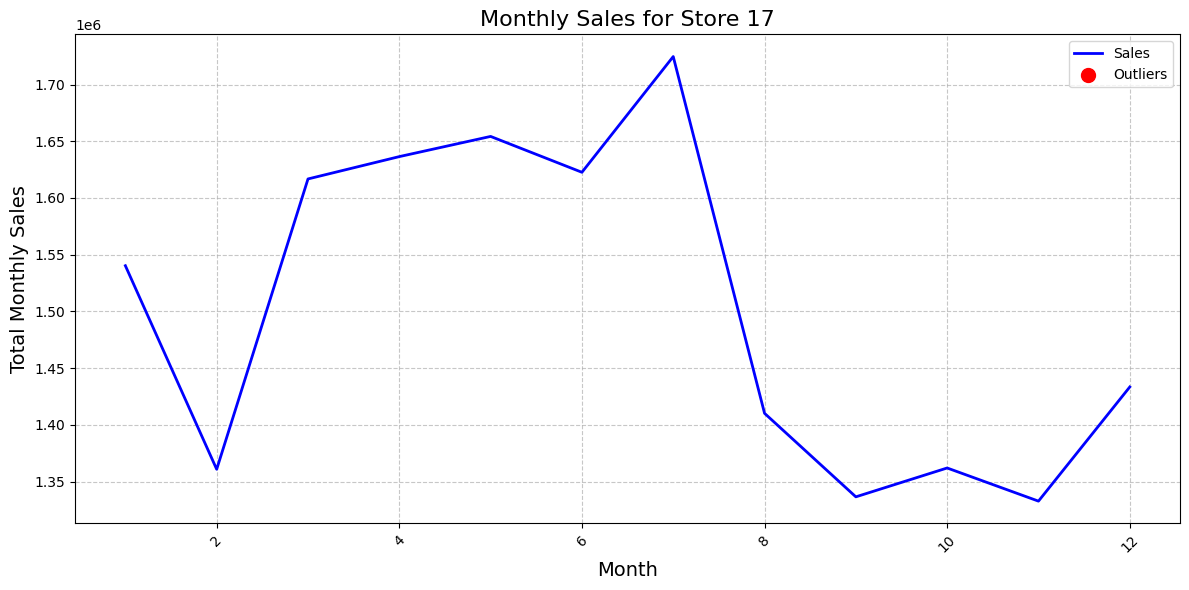

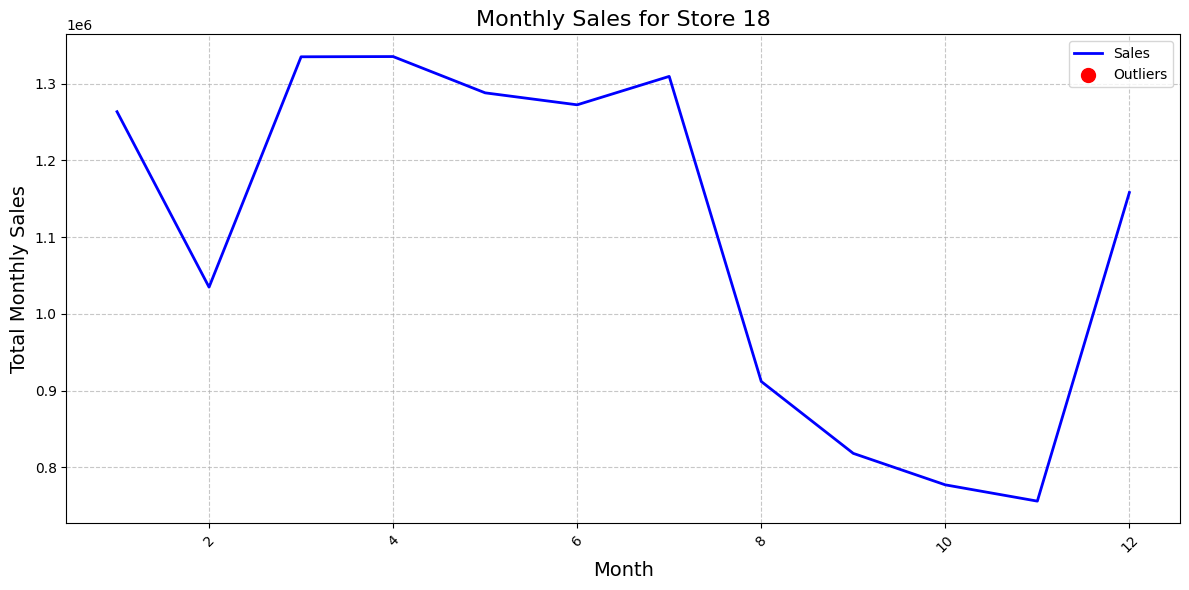

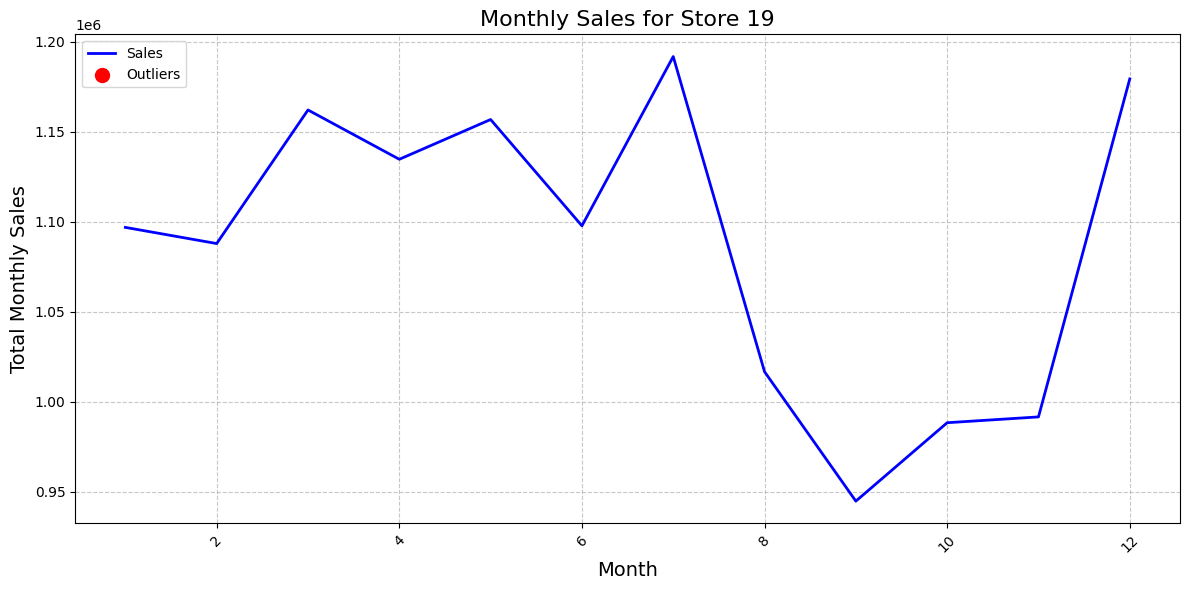

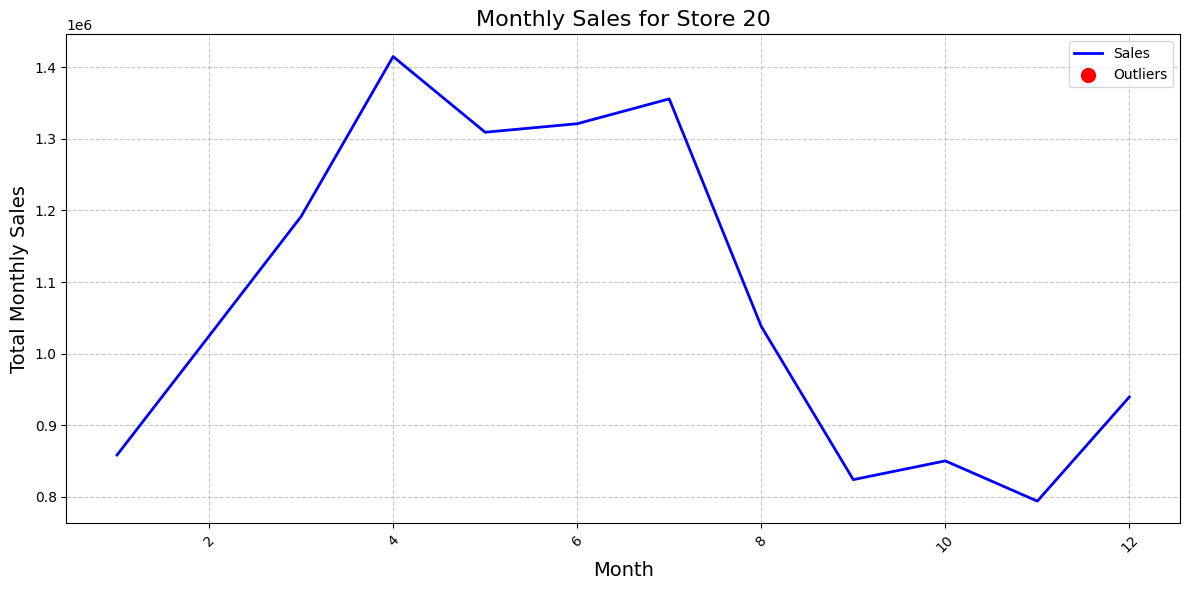

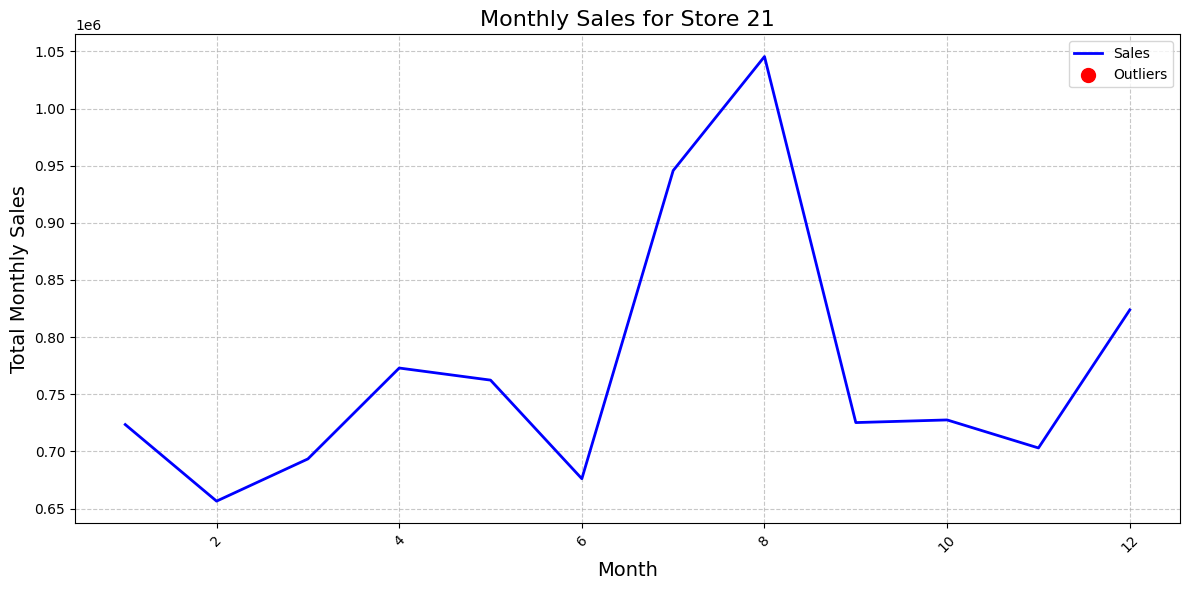

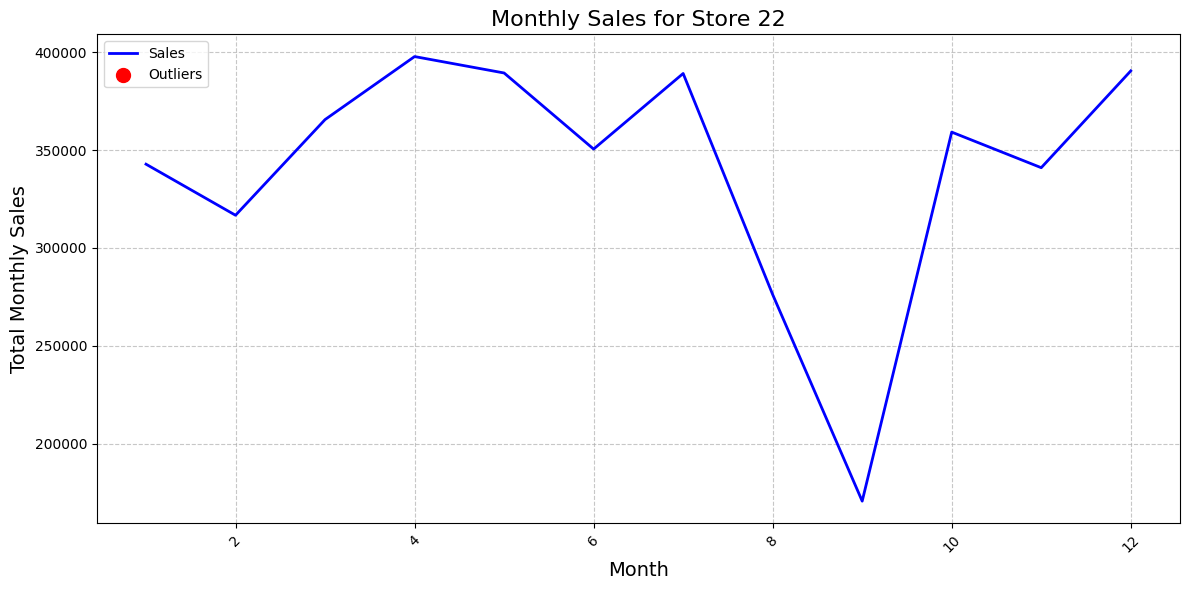

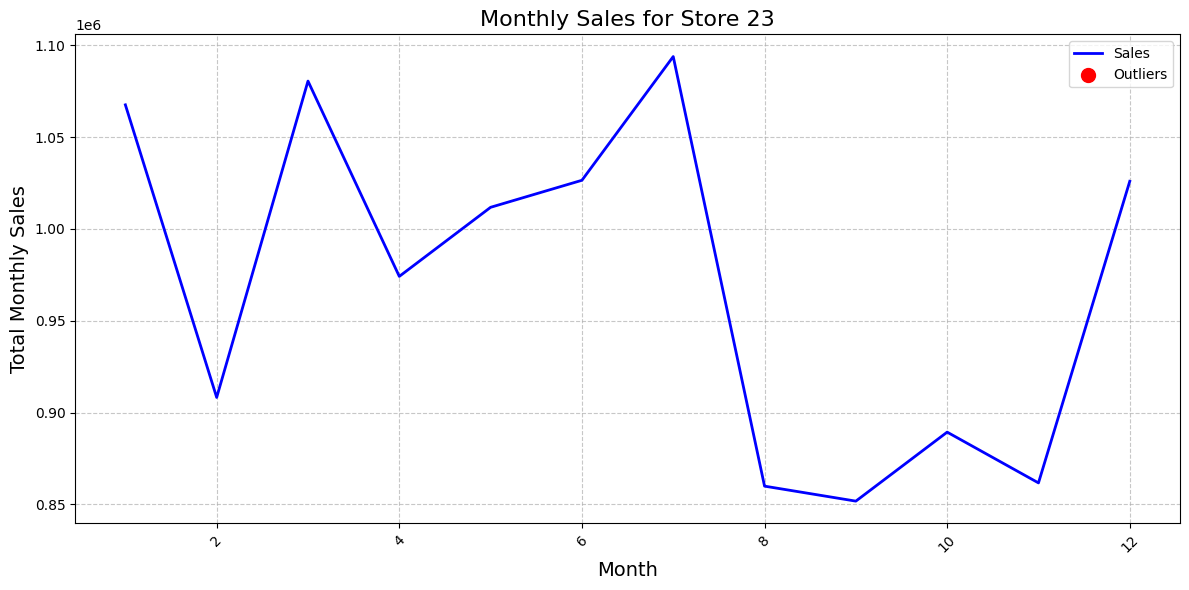

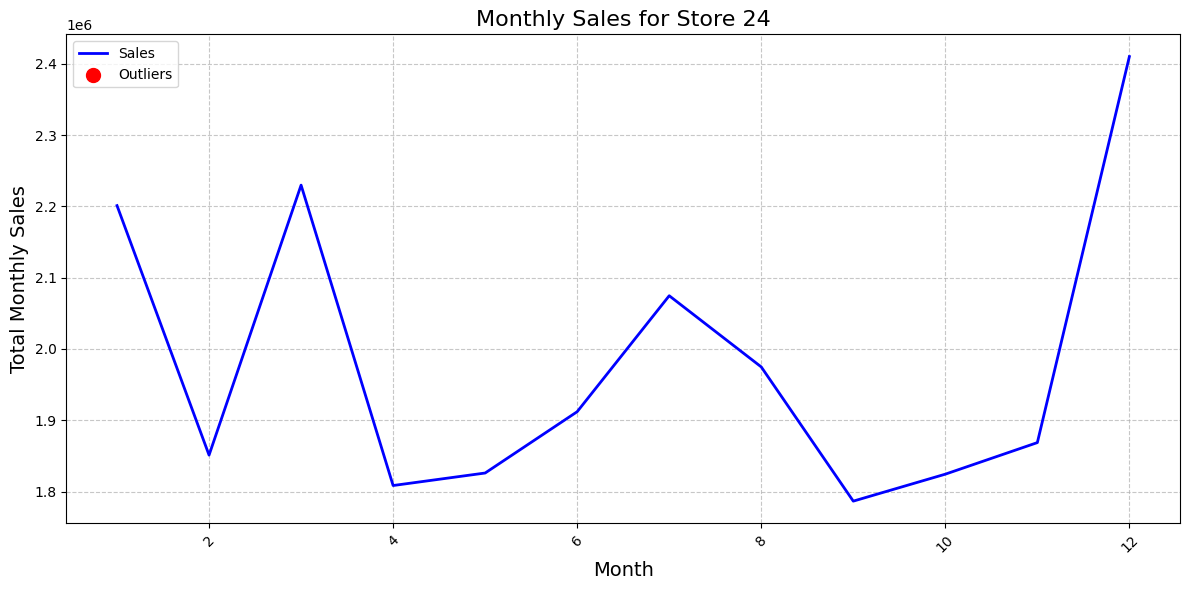

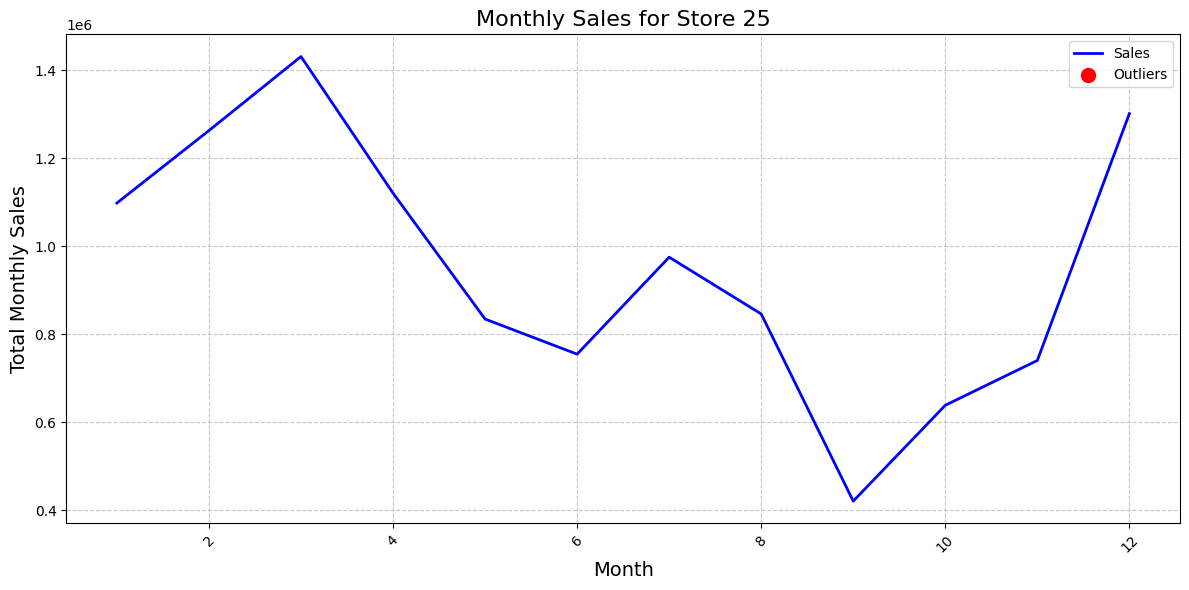

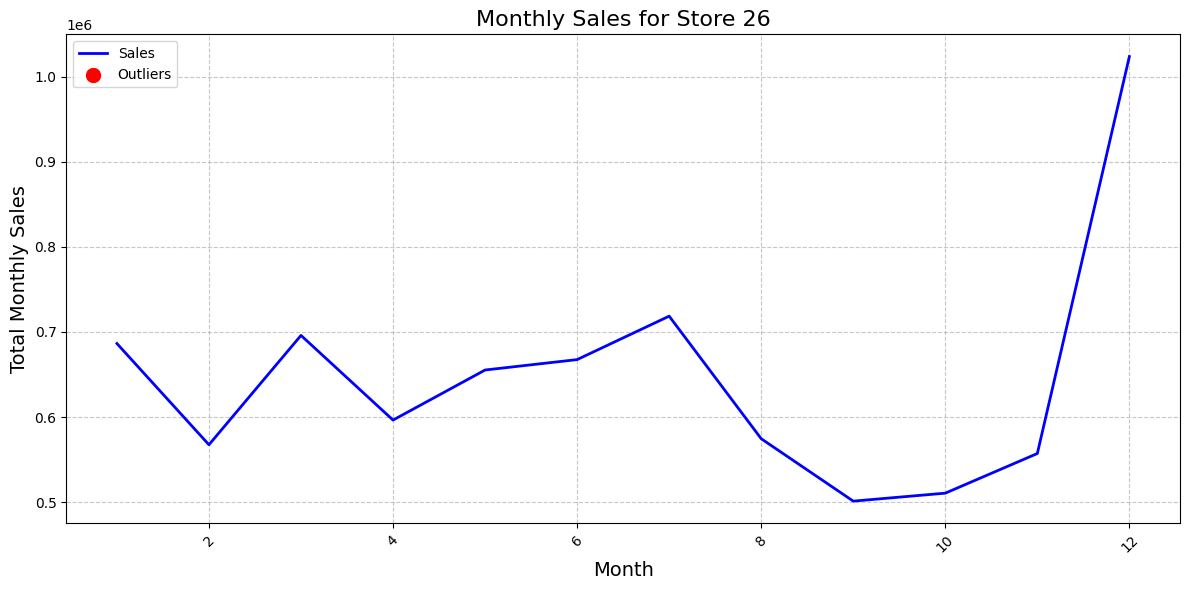

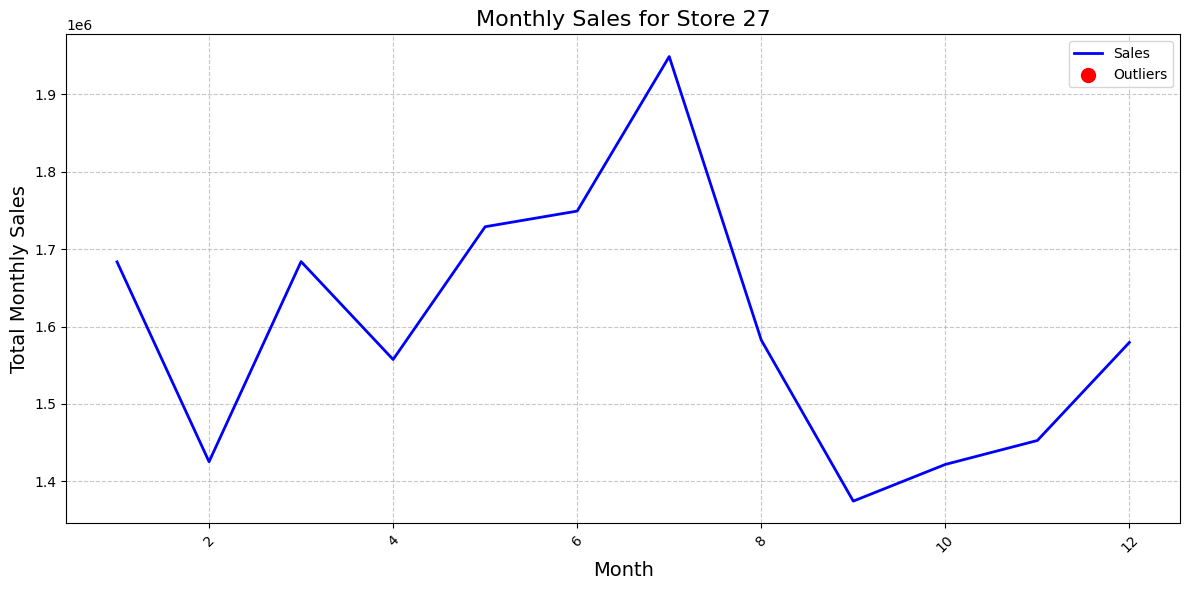

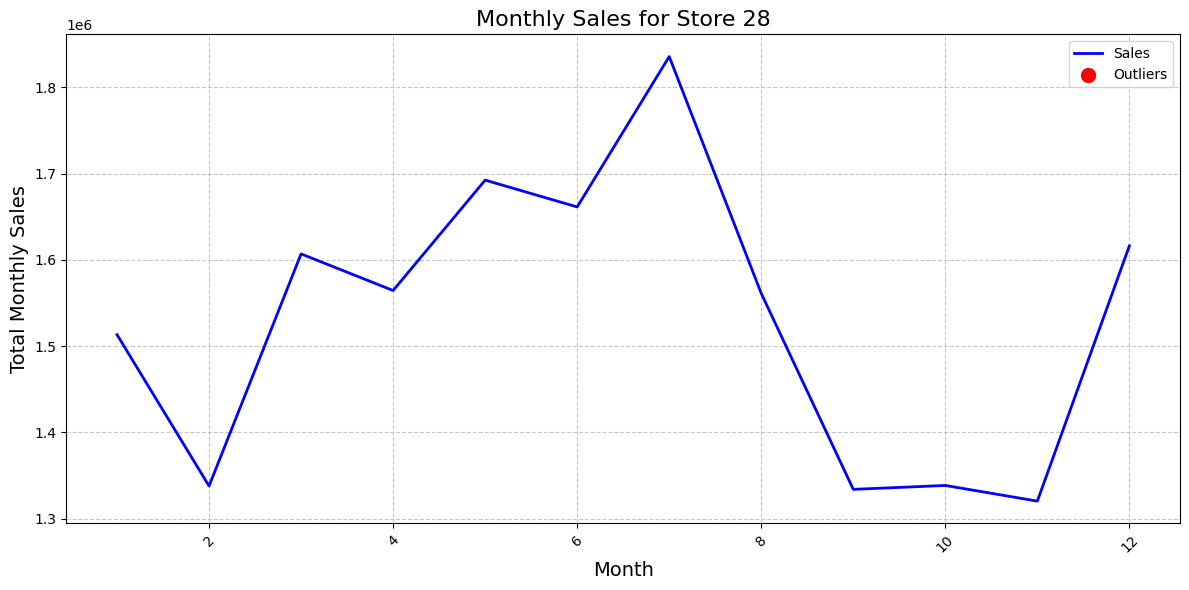

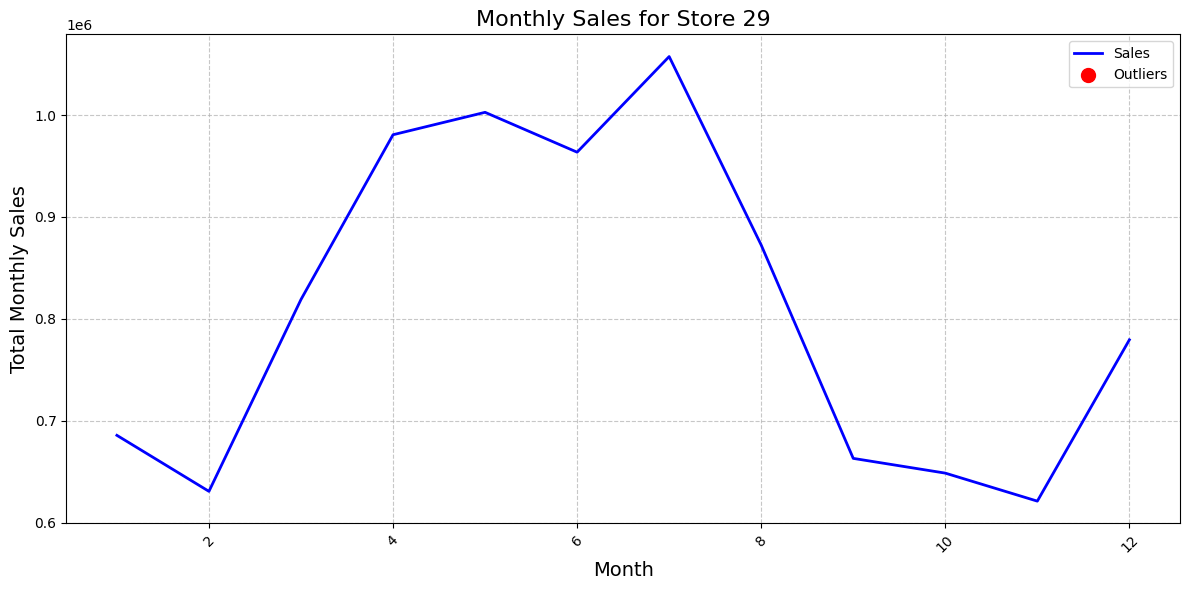

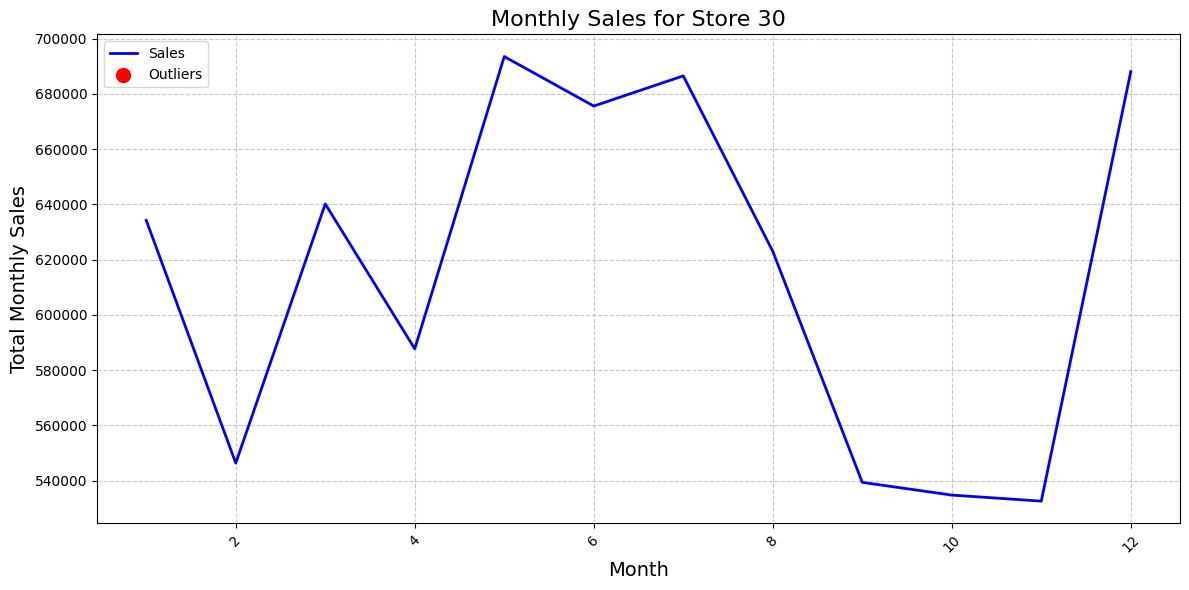

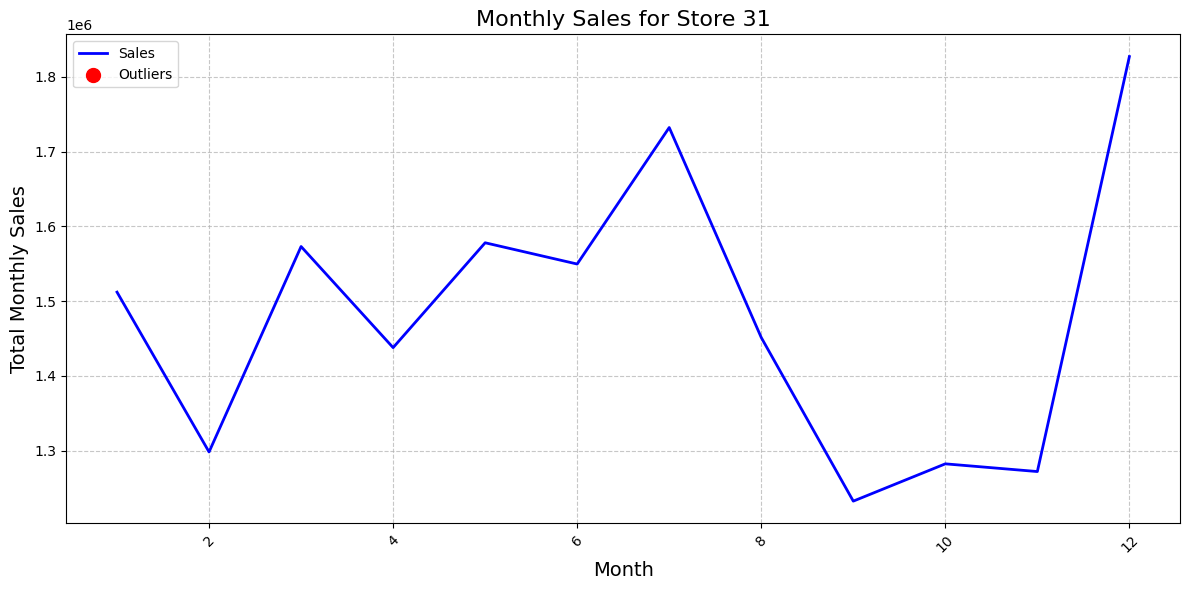

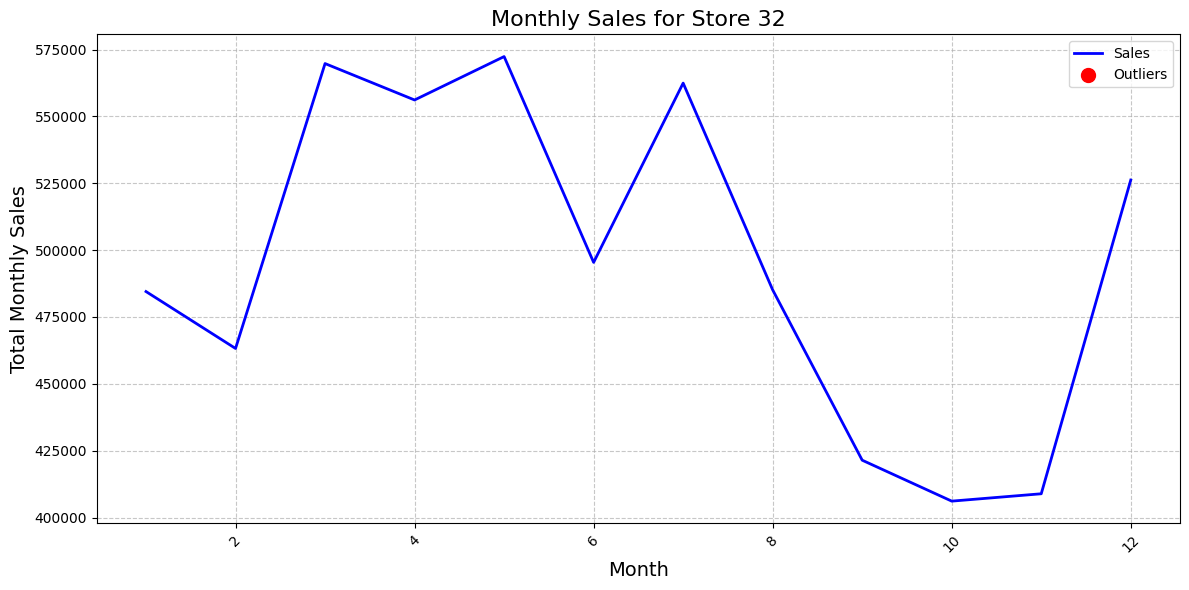

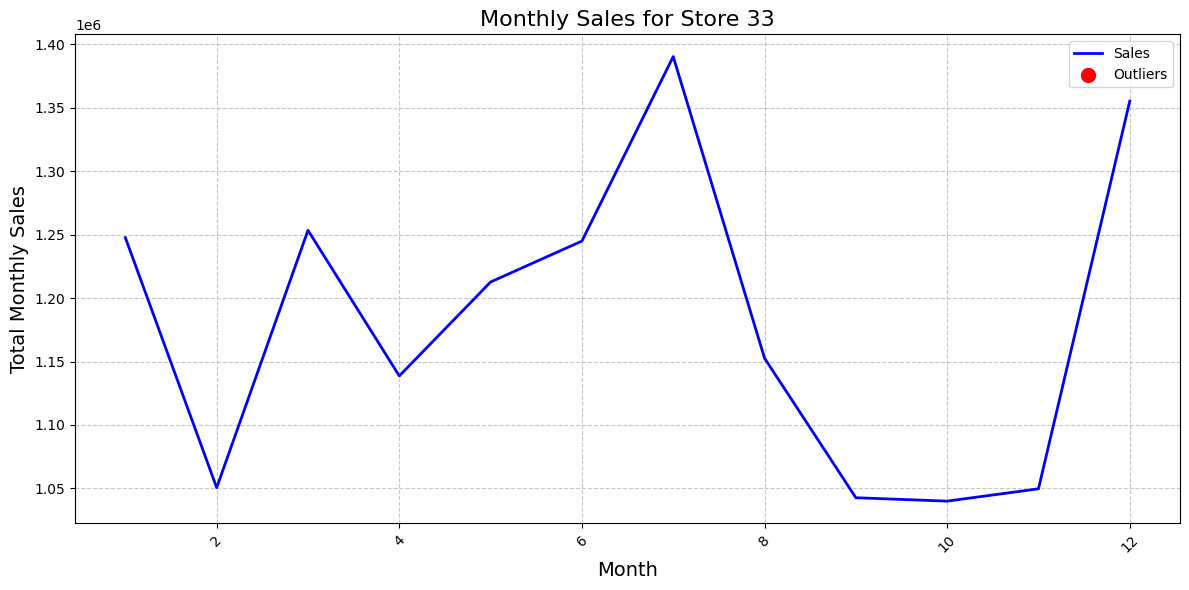

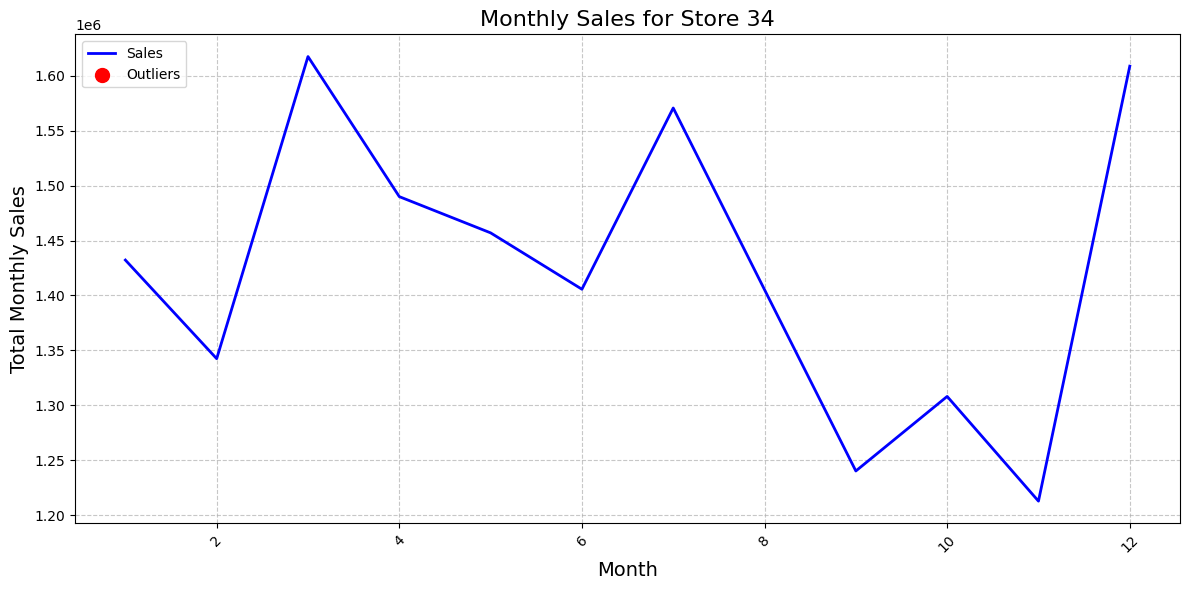

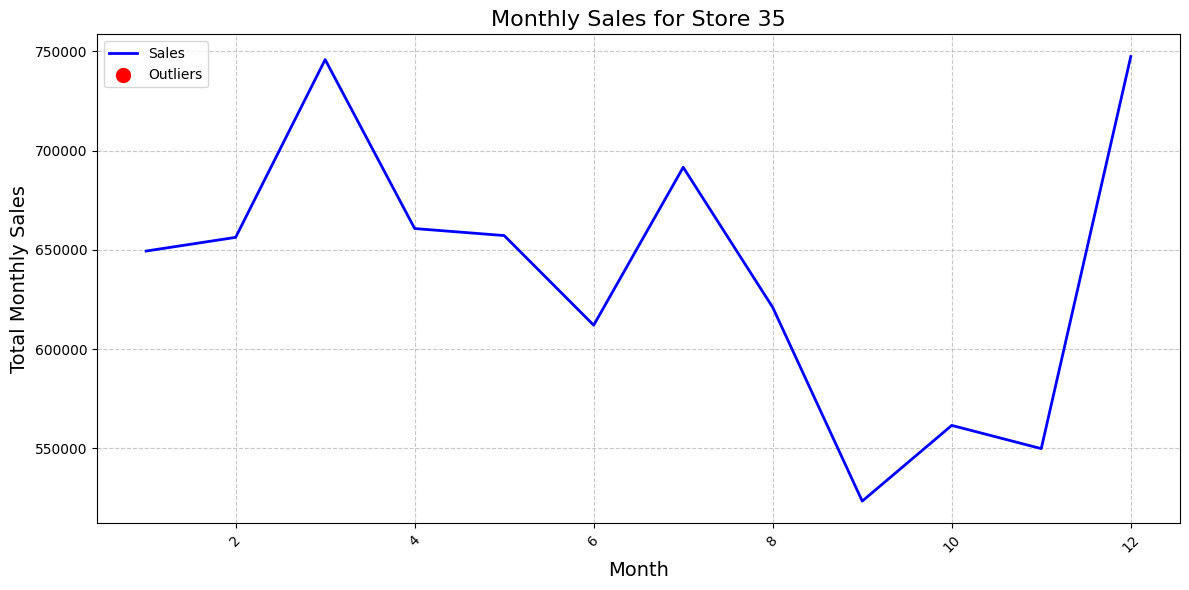

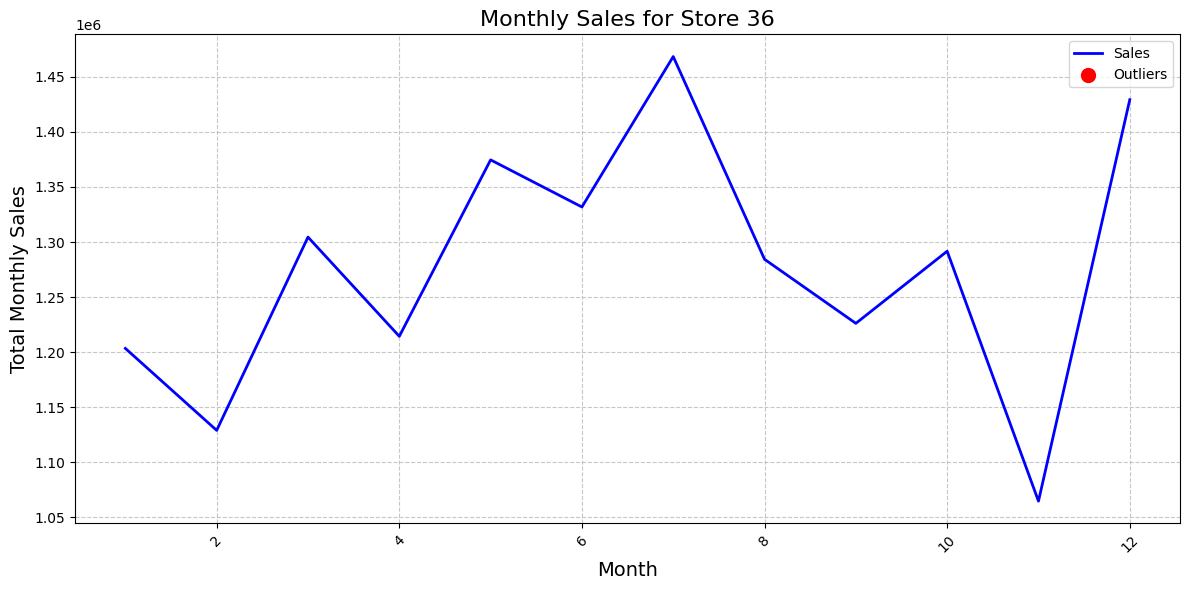

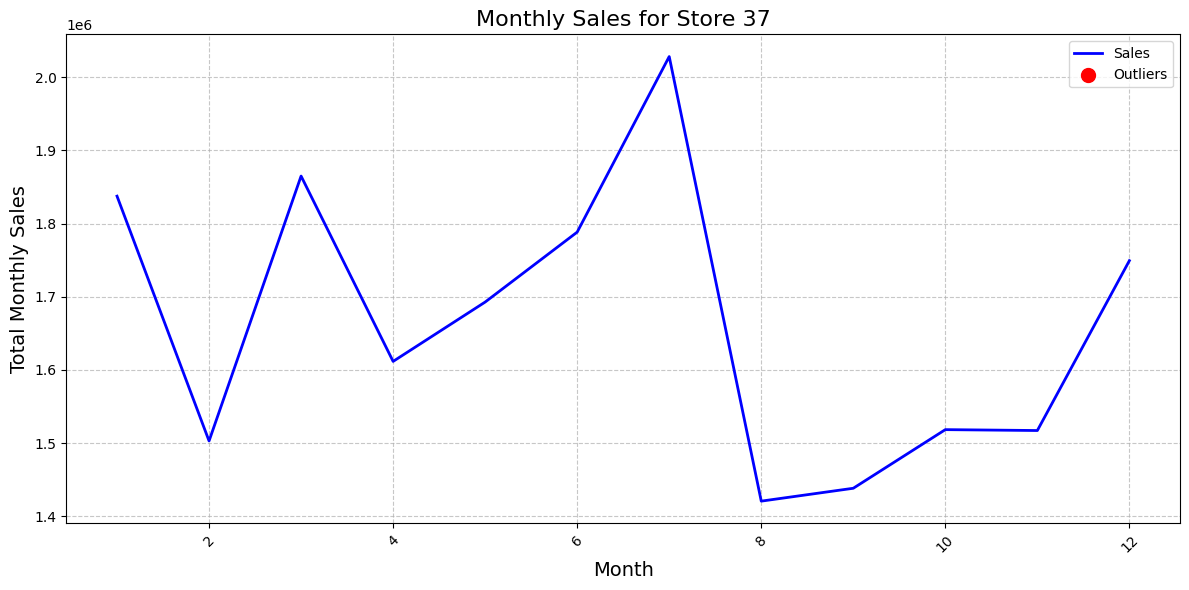

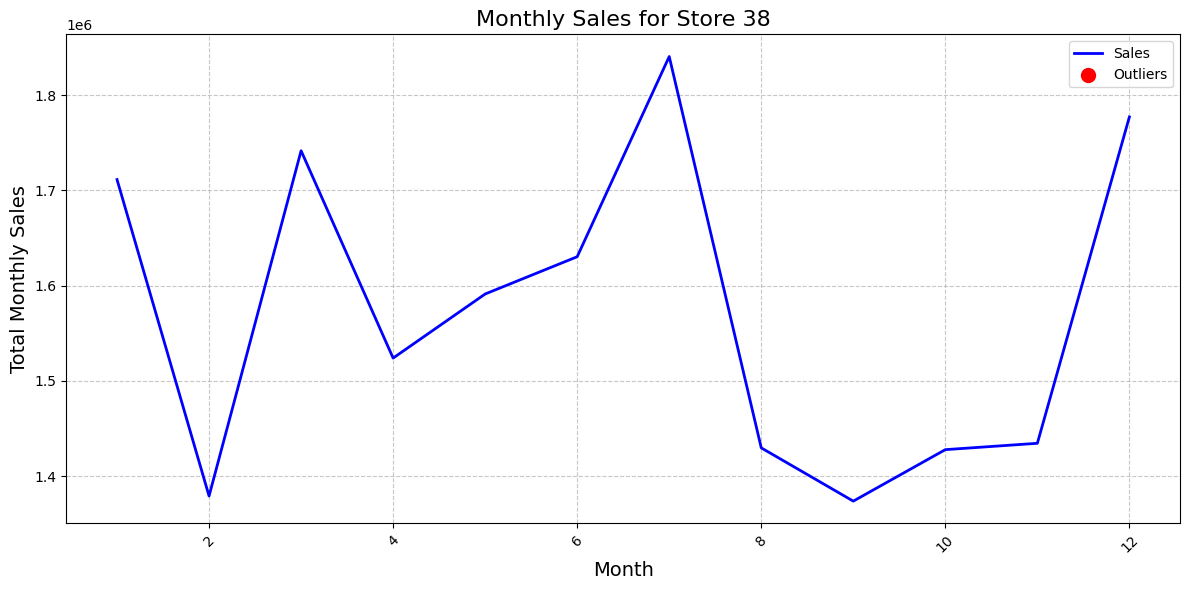

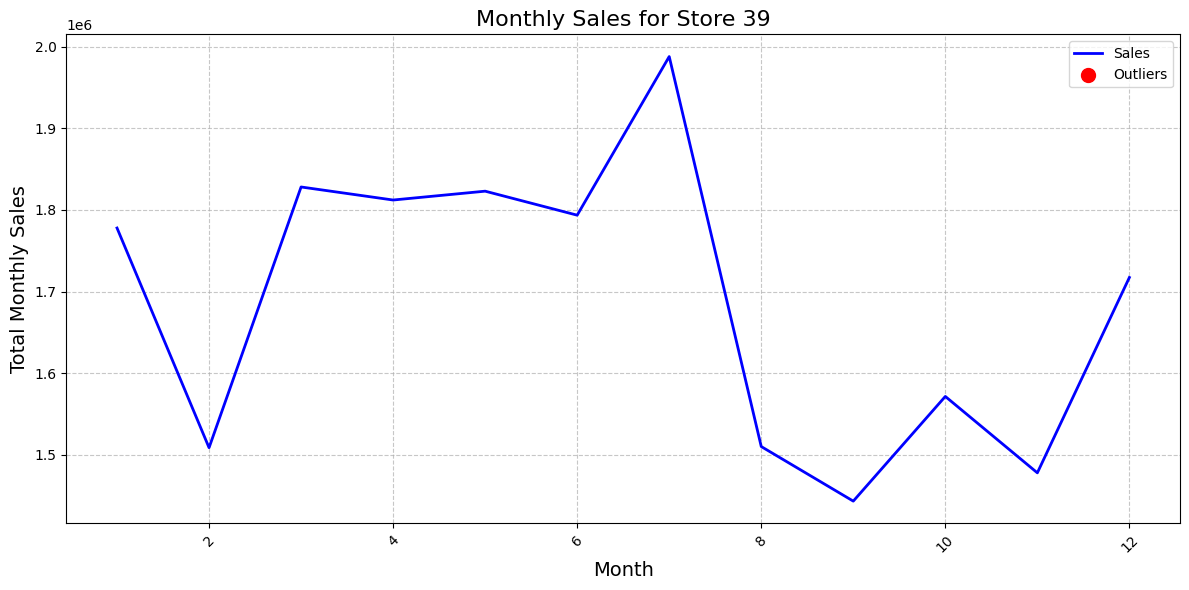

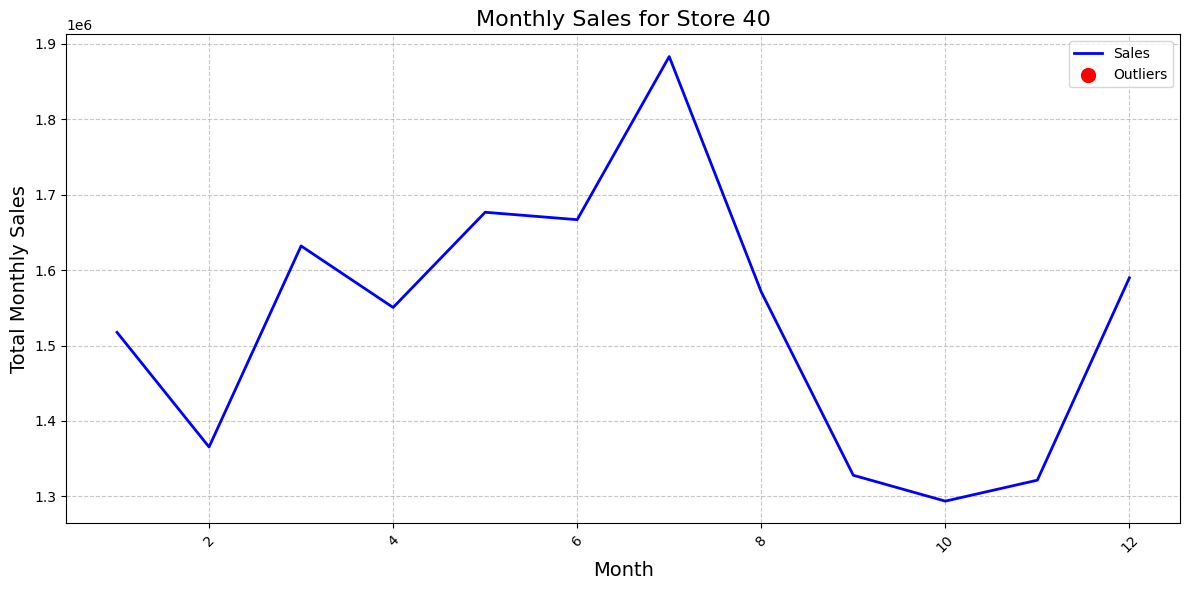

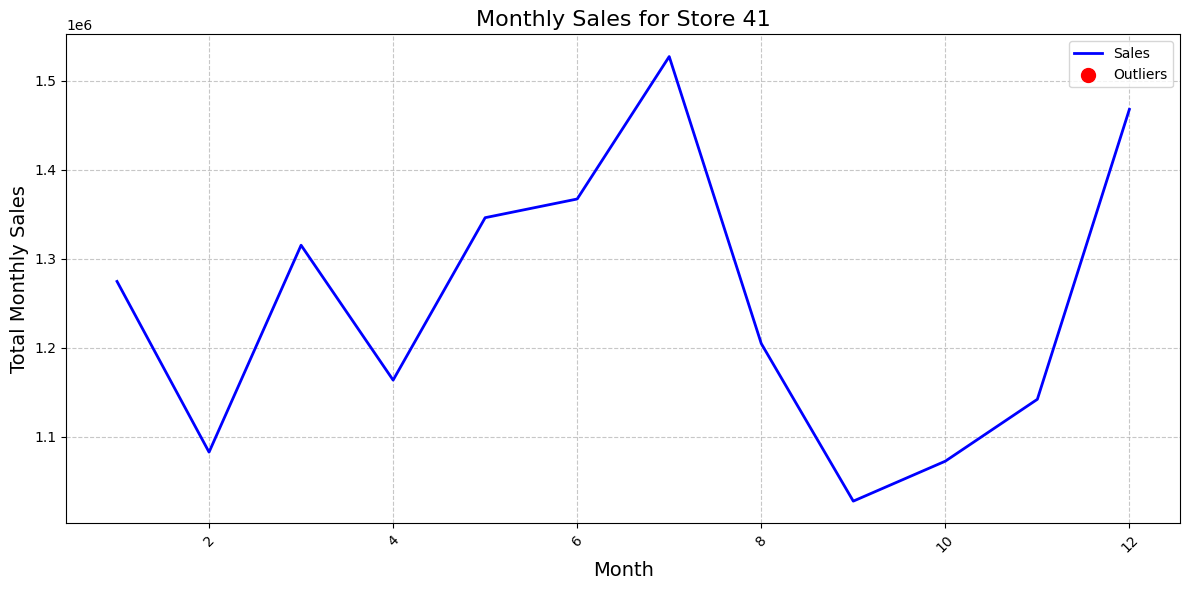

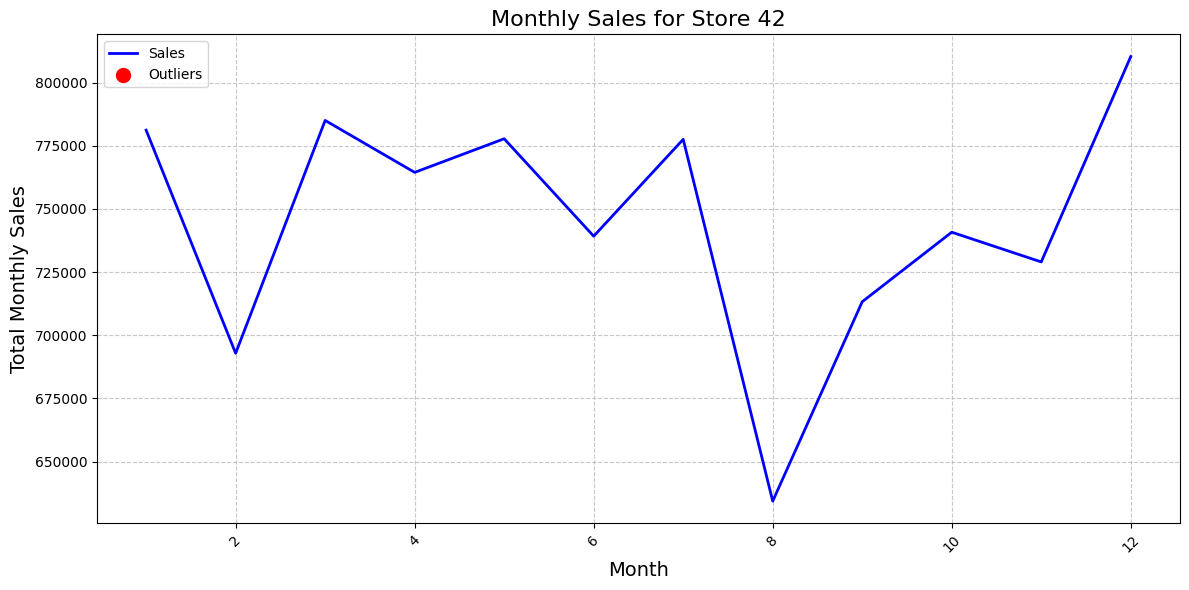

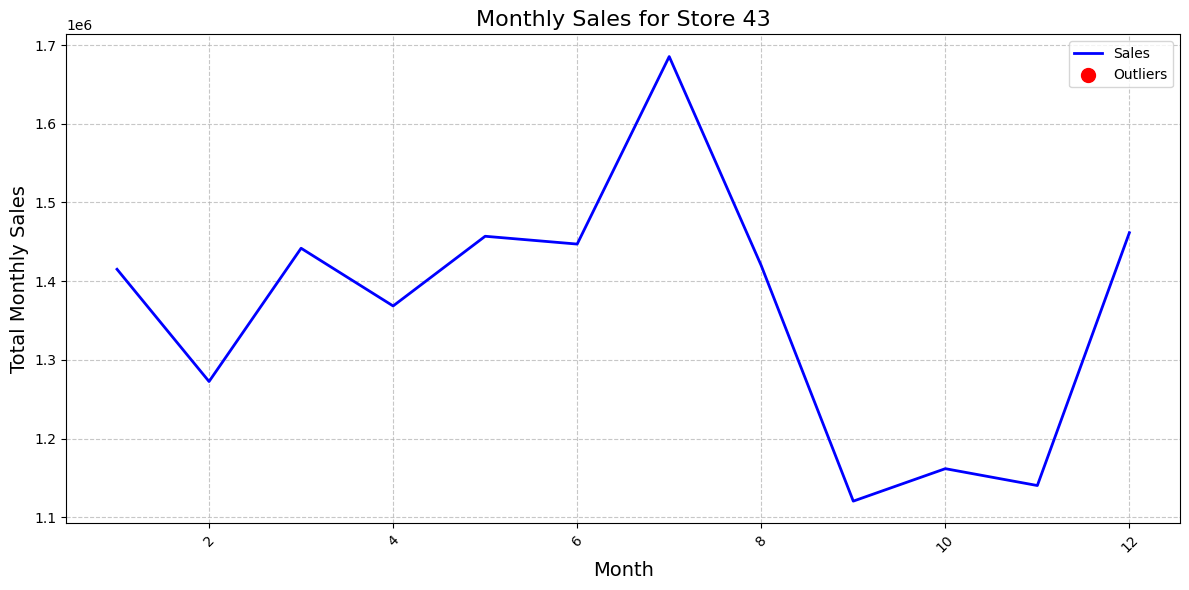

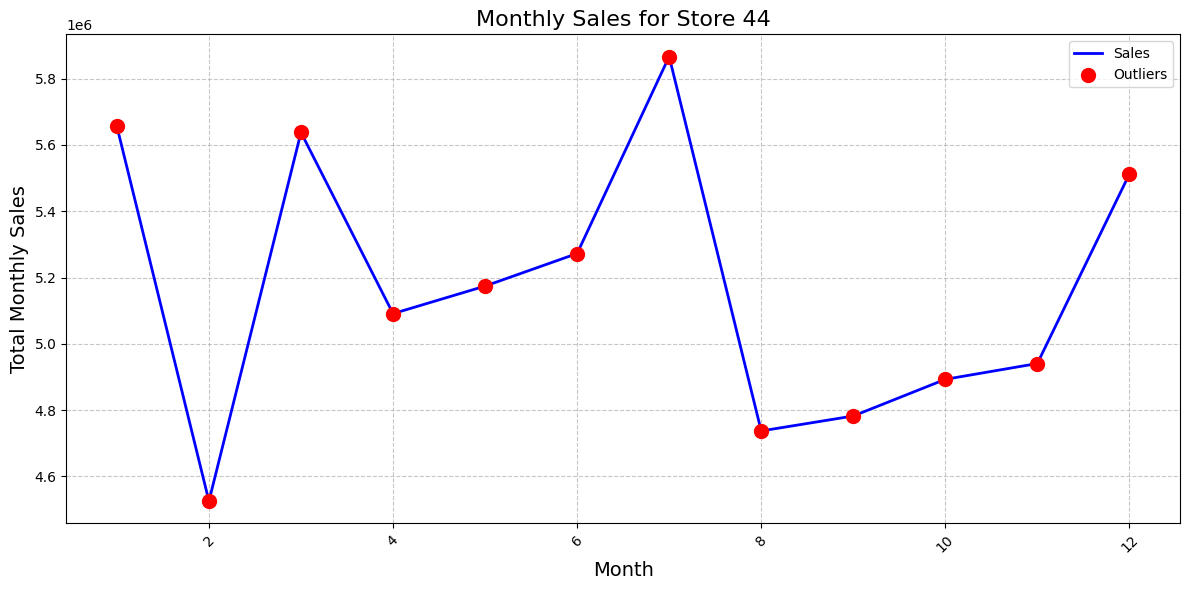

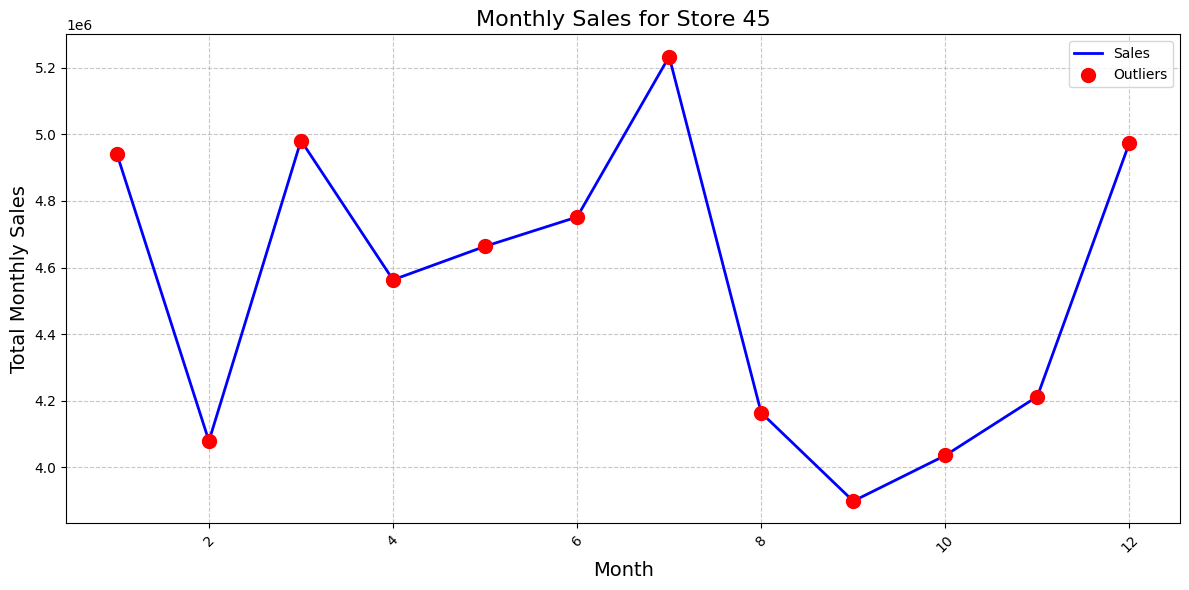

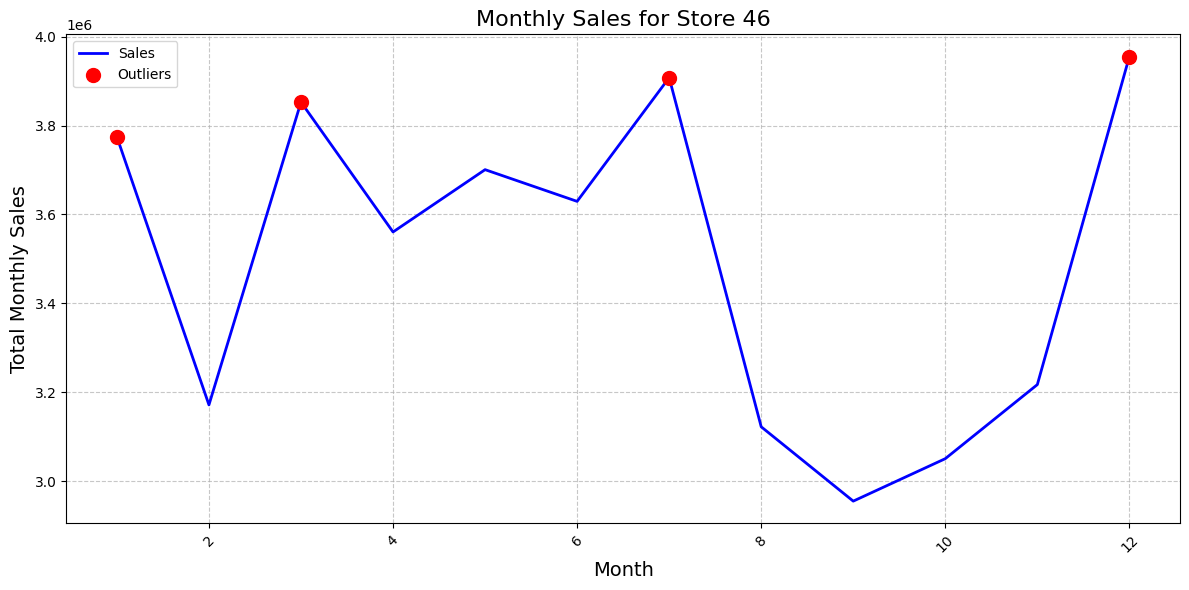

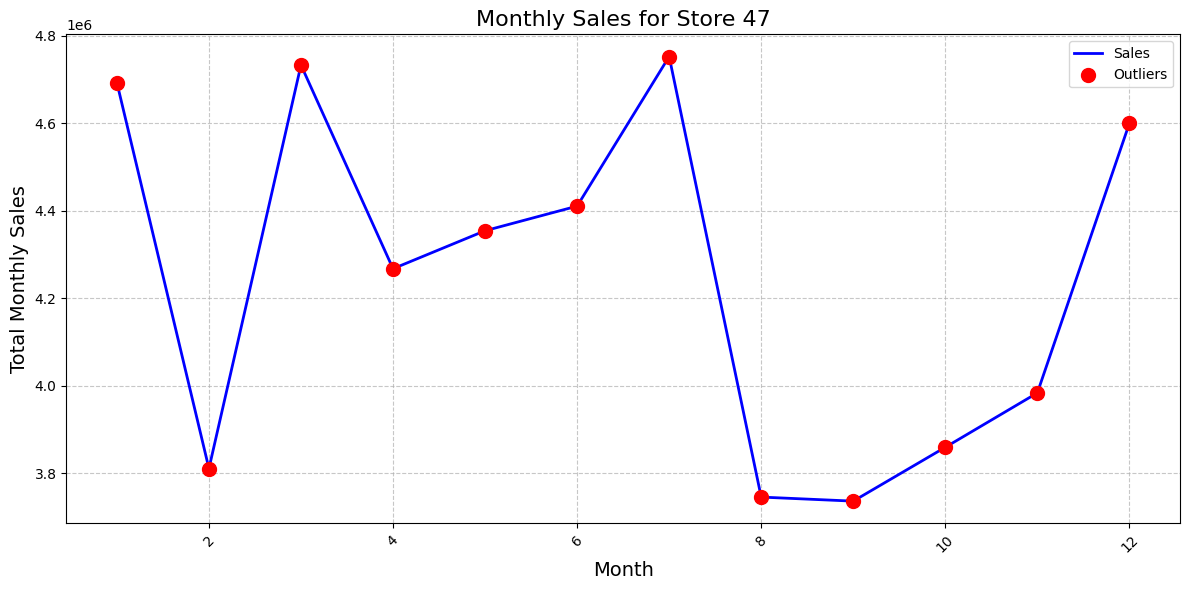

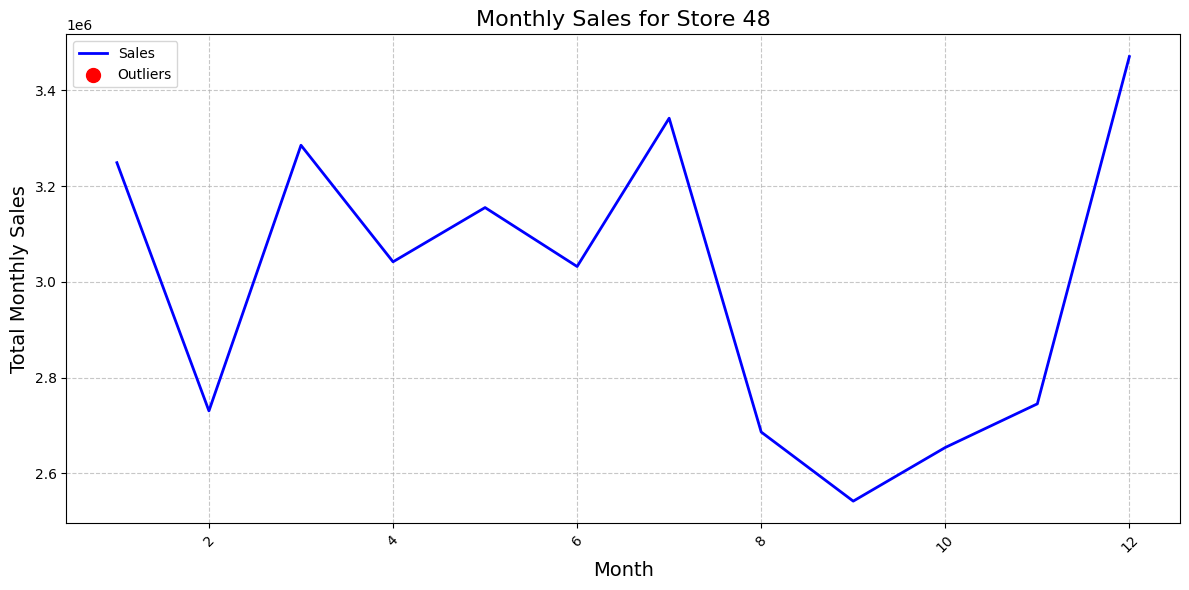

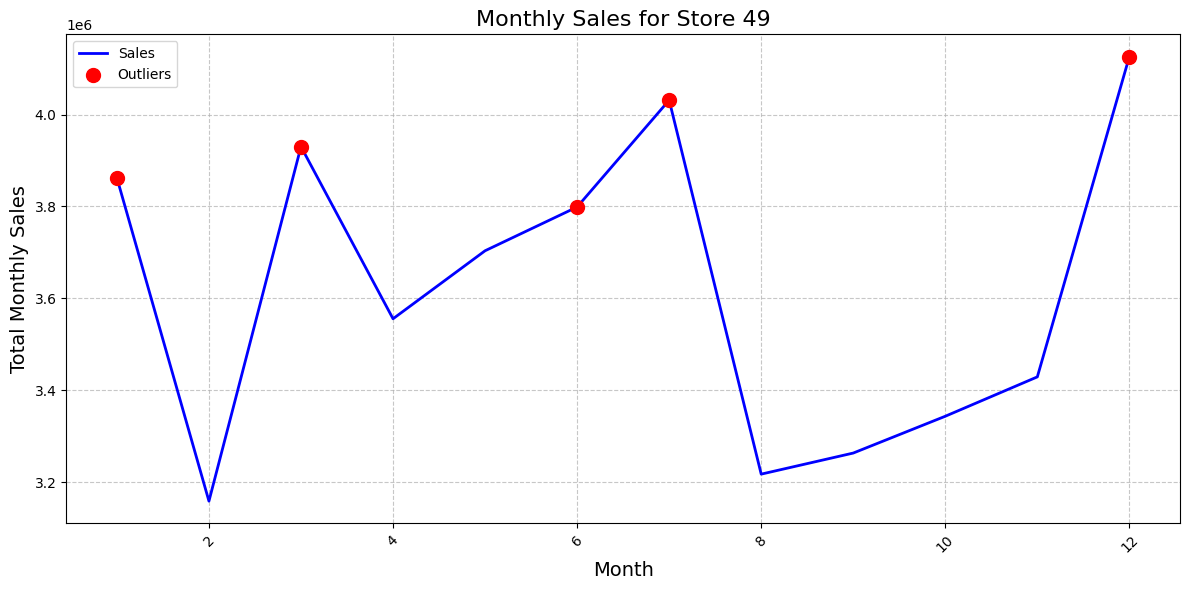

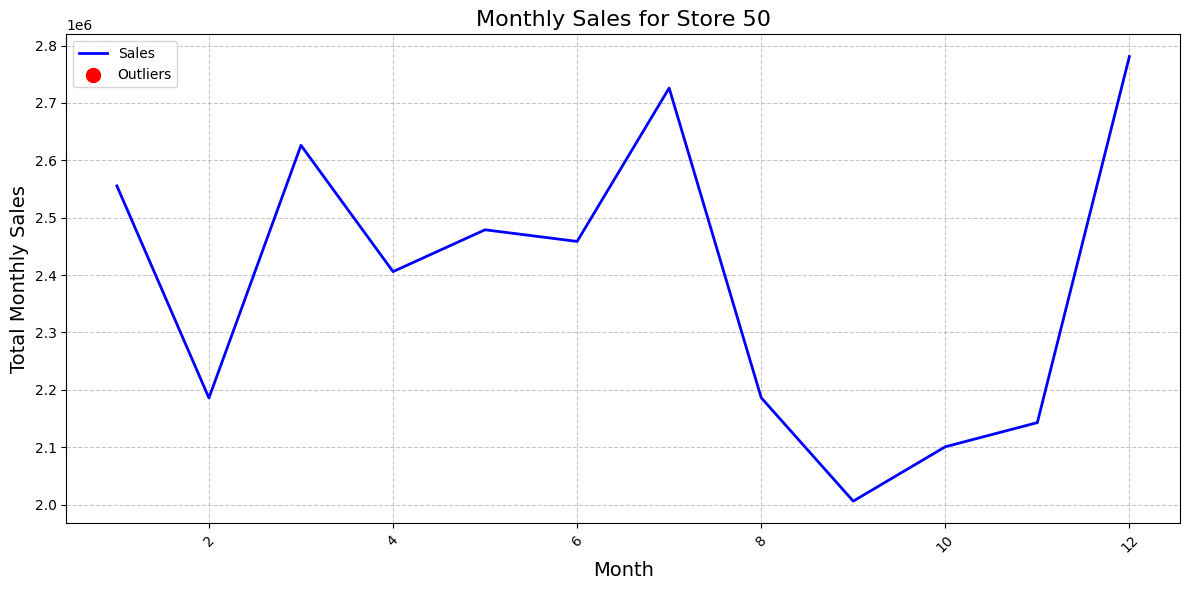

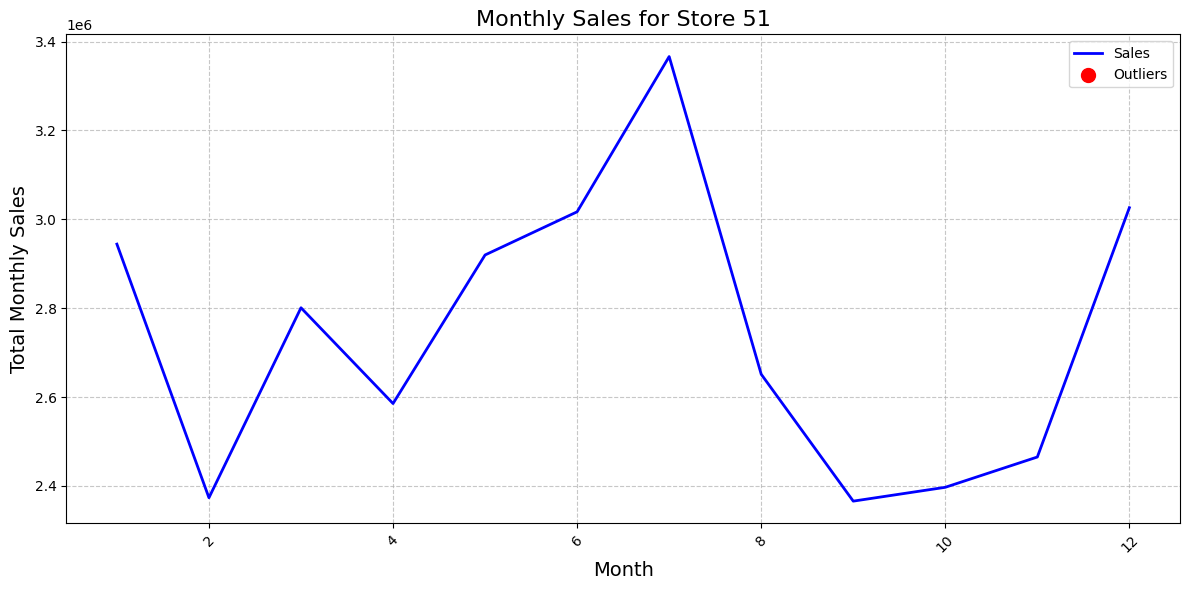

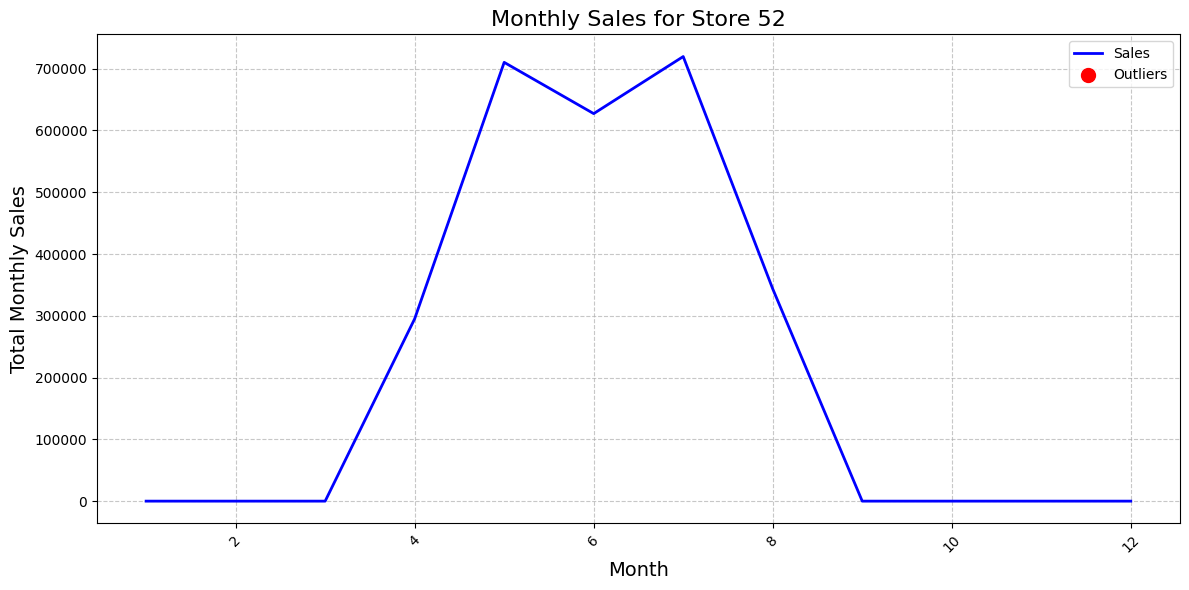

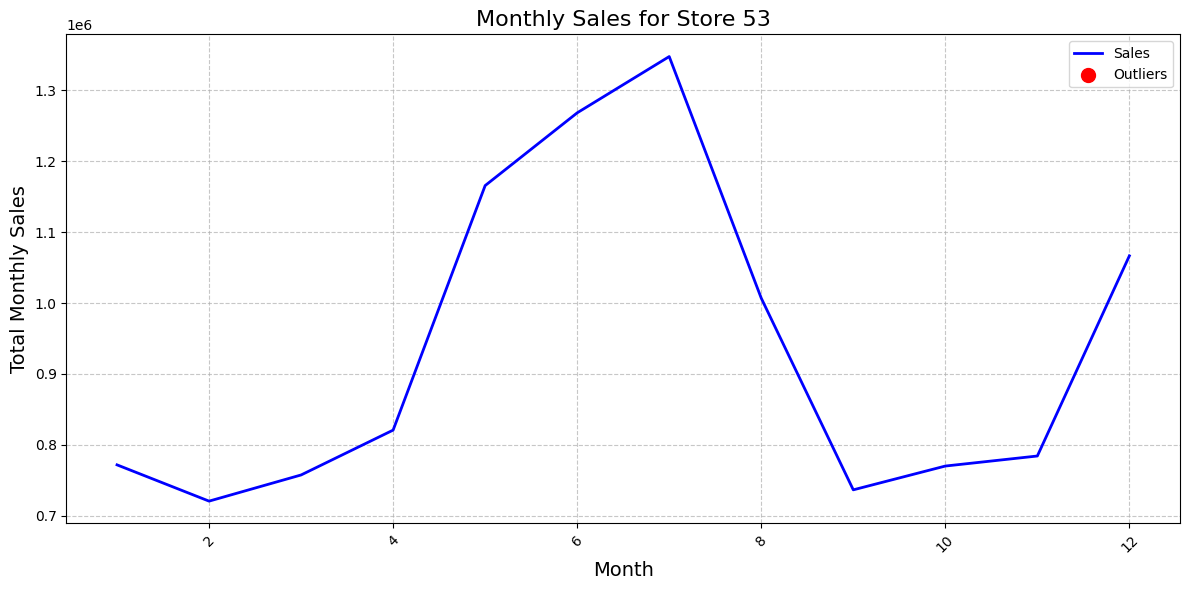

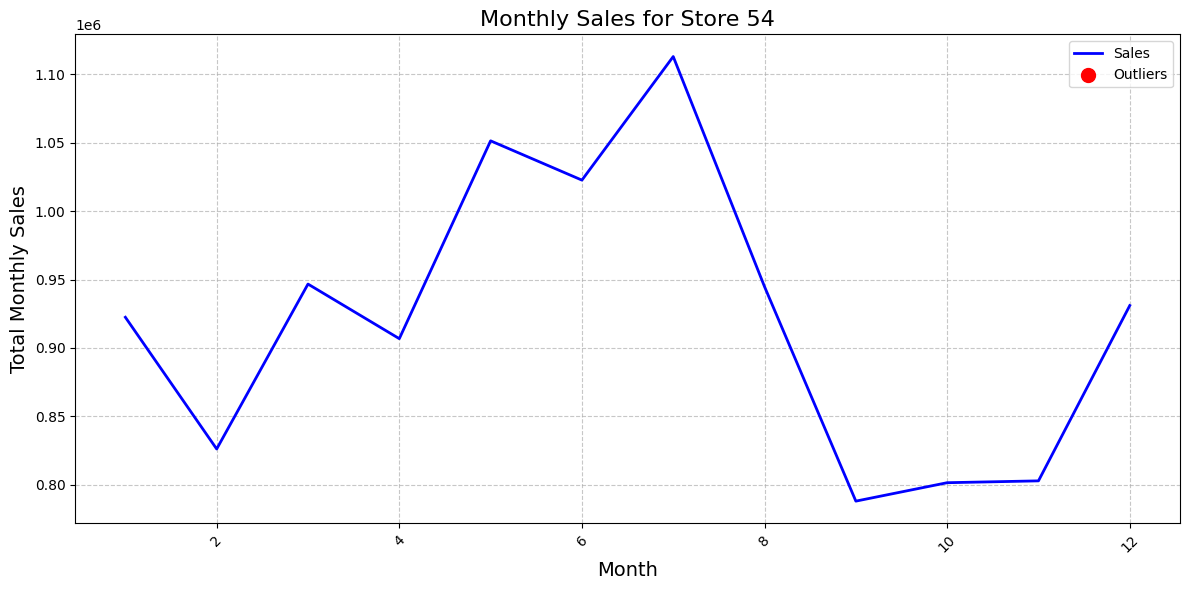

In [99]:
import matplotlib.pyplot as plt

# Function to plot time series for each store
def plot_store_sales_with_outliers(df: pd.DataFrame):
    
    for store in df['store_nbr'].unique():
        # Filter data for the current store
        store_data = df[df['store_nbr'] == store].copy()
        
        # Retrieve the outliers
        outliers = store_data[store_data['outlier']]
        
        # Create the plot
        plt.figure(figsize=(12, 6))
        plt.plot(store_data['month'], store_data['monthly_sales_totals'], 
                 label='Sales', color='blue', linewidth=2)
        plt.scatter(outliers['month'], outliers['monthly_sales_totals'], 
                    color='red', label='Outliers', s=100, zorder=5)
        
        # Labels and title
        plt.title(f'Monthly Sales for Store {store}', fontsize=16)
        plt.xlabel('Month', fontsize=14)
        plt.ylabel('Total Monthly Sales', fontsize=14)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_store_sales_with_outliers(monthly_sales_totals)

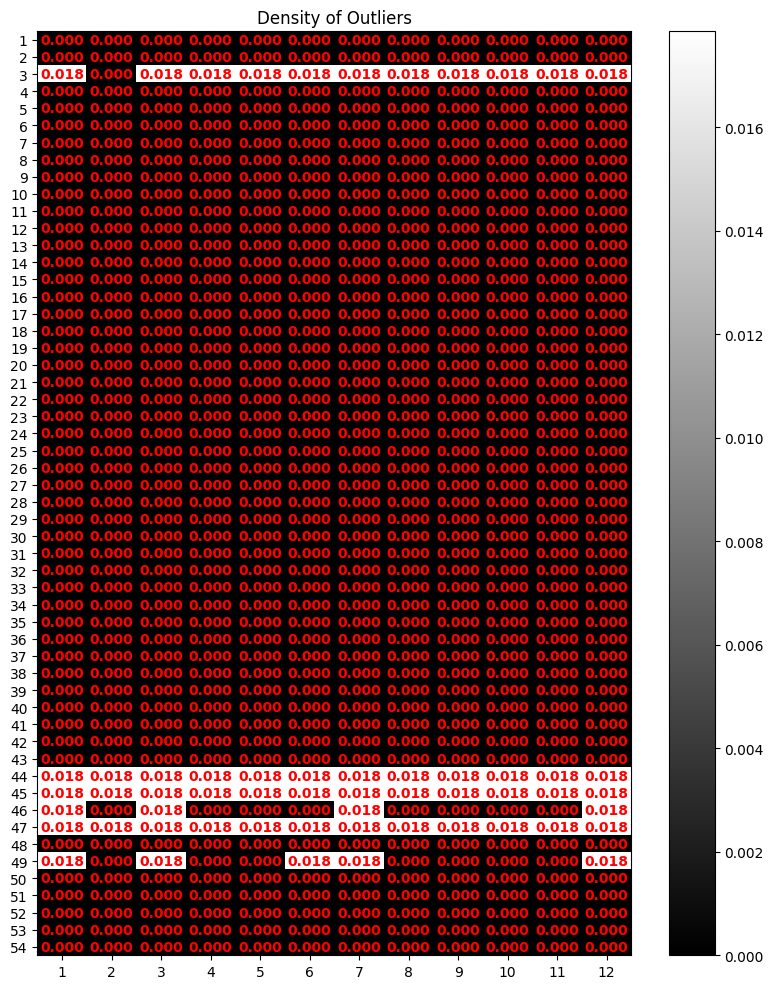

In [100]:
def plot_outlier_density_heatmap(pivot_table: pd.DataFrame):
    # Create heatmap with annotations
    _, ax = plt.subplots(figsize=(8, 10))
    im = ax.imshow(pivot_table.values, cmap='grey', aspect='auto')

    # Add annotations (values) to each cell
    for i in range(len(pivot_table.index)):
        for j in range(len(pivot_table.columns)):
            value = pivot_table.iloc[i, j]
            ax.text(j, i, f"{value:.3f}",
                        ha="center", va="center", color="red", fontweight='bold')

    # Customize the plot
    ax.set_xticks(range(len(pivot_table.columns)))
    ax.set_yticks(range(len(pivot_table.index)))
    ax.set_xticklabels(pivot_table.columns)
    ax.set_yticklabels(pivot_table.index)

    # Add colorbar
    plt.colorbar(im)
    plt.title('Density of Outliers')
    plt.tight_layout()
    plt.show()

# Pivot to get count of outliers per (store, month)
# Only count rows where outlier == True
outlier_counts = monthly_sales_totals.pivot_table(values='outlier',index='store_nbr',columns='month',aggfunc='sum',fill_value=0)
outlier_density = outlier_counts/monthly_sales_totals['outlier'].sum()
"""
    Create a colorblind-accessible heatmap showing the density of outliers 
    by store and by month.
"""
plot_outlier_density_heatmap(outlier_density)

In [101]:
# Retrieve the two stores with the most detected outliers
idx = monthly_sales_totals.groupby('store_nbr')['outlier'].sum().sort_values(ascending=False).index
two_stores_with_the_most_detected_outliers = idx[:2].values
two_stores_with_the_most_detected_outliers

array([47, 44])

In [102]:
# Load the store dataset
store = pd.read_csv('stores.csv',index_col=0)
store.head()

city                           state type  cluster
store_nbr                                                             
1                  Quito                       Pichincha    D       13
2                  Quito                       Pichincha    D       13
3                  Quito                       Pichincha    D        8
4                  Quito                       Pichincha    D        9
5          Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [103]:
# Obtain information on all the stores in the order of non-ascending number of outliers
store.loc[idx]

city                           state type  cluster
store_nbr                                                             
47                 Quito                       Pichincha    A       14
44                 Quito                       Pichincha    A        5
45                 Quito                       Pichincha    A       11
3                  Quito                       Pichincha    D        8
49                 Quito                       Pichincha    A       11
46                 Quito                       Pichincha    A       14
7                  Quito                       Pichincha    D        8
8                  Quito                       Pichincha    D        8
9                  Quito                       Pichincha    B        6
10                 Quito                       Pichincha    C       15
11               Cayambe                       Pichincha    B        6
12             Latacunga                        Cotopaxi    C       15
13             Latacunga                        Cotopaxi    C       15
14              Riobamba                      Chimborazo    C        7
15                Ibarra                        Imbabura    C       15
16         Santo Domingo  Santo Domingo de los Tsachilas    C        3
17                 Quito                       Pichincha    C       12
1                  Quito                       Pichincha    D       13
2                  Quito                       Pichincha    D       13
4                  Quito                       Pichincha    D        9
5          Santo Domingo  Santo Domingo de los Tsachilas    D        4
6                  Quito                       Pichincha    D       13
22                  Puyo                         Pastaza    C        7
21         Santo Domingo  Santo Domingo de los Tsachilas    B        6
20                 Quito                       Pichincha    B        6
19              Guaranda                         Bolivar    C       15
18                 Quito                       Pichincha    B       16
23                Ambato                      Tungurahua    D        9
25               Salinas                     Santa Elena    D        1
24             Guayaquil                          Guayas    D        1
31              Babahoyo                        Los Rios    B       10
32             Guayaquil                          Guayas    C        3
33               Quevedo                        Los Rios    C        3
26             Guayaquil                          Guayas    D       10
27                 Daule                          Guayas    D        1
28             Guayaquil                          Guayas    E       10
29             Guayaquil                          Guayas    E       10
30             Guayaquil                          Guayas    C        3
38                  Loja                            Loja    D        4
37                Cuenca                           Azuay    D        2
36              Libertad                          Guayas    E       10
35                Playas                          Guayas    C        3
34             Guayaquil                          Guayas    B        6
41               Machala                          El Oro    D        4
42                Cuenca                           Azuay    D        2
39                Cuenca                           Azuay    B        6
43            Esmeraldas                      Esmeraldas    E       10
40               Machala                          El Oro    C        3
48                 Quito                       Pichincha    A       14
50                Ambato                      Tungurahua    A       14
51             Guayaquil                          Guayas    A       17
52                 Manta                          Manabi    A       11
53                 Manta                          Manabi    D       13
54             El Carmen                          Manabi    C        3

In [105]:
# Load the transactions dataset
transactions = pd.read_csv('transactions.csv')
transactions.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

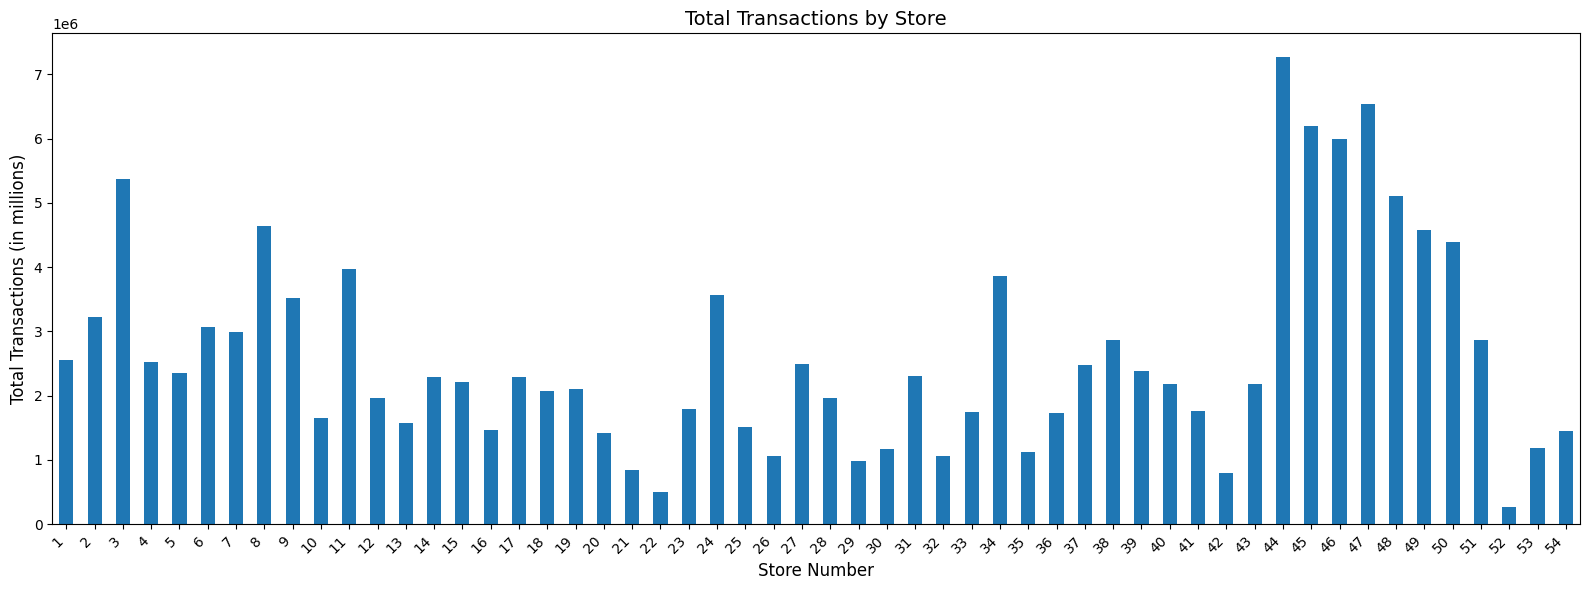

In [106]:
# Create bar plot with larger figure
plt.figure(figsize=(16, 6))  # Wider figure for more space
# Display total transactions of each store in the dataset.
transactions.groupby('store_nbr')['transactions'].sum().plot(kind='bar')
# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')  # 45-degree rotation, align right

# Add labels and title
plt.xlabel('Store Number', fontsize=12)
plt.ylabel('Total Transactions (in millions)', fontsize=12)
plt.title('Total Transactions by Store', fontsize=14)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()

Two of the most predominant statistical outliers in sales patterns are for stores located in Quito, Pichincha. They also have the largest total transactions in comparison to other stores.